# Nicholas W.: Forecasting Consensus Expectations of Nonfarm Payrolls (NFP)

# Forecasting pipeline

**Imports**

In [1]:
import os
import warnings
import math
import json
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from typing import List, Tuple, Dict, Any
from scipy import stats, special
from scipy.optimize import brentq, minimize
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from sklearn.mixture import GaussianMixture
from collections import defaultdict
from itertools import product
from arch.univariate import ConstantMean, GARCH, StudentsT
from arch.univariate.base import ConvergenceWarning
from IPython.display import display, Markdown
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from pandas.tseries.offsets import MonthBegin

warnings.filterwarnings("ignore")

In [2]:
OUT_DIR = "../out"        
DF_FILE       = "nfp_df.parquet"
DF_FULL_FILE  = "nfp_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (17046, 10)
df_full shape: (19375, 10)


In [3]:
df.head()

,release_date,period,actual,median_forecast,economist,firm,forecast,asof,surprise,error
0,2003-06-06,2003-05-31,-17.0,-30.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,-15.0,2003-06-04,13.0,2.0
1,2003-06-06,2003-05-31,-17.0,-30.0,Alison Lynn Reaser,Point Loma Nazarene University,-15.0,2003-05-30,13.0,2.0
2,2003-06-06,2003-05-31,-17.0,-30.0,Anthony Chan,JPMorgan Chase Bank,-70.0,2003-05-30,13.0,-53.0
3,2003-06-06,2003-05-31,-17.0,-30.0,Aurelio Maccario,UniCredit Spa,-9.0,2003-05-30,13.0,8.0
4,2003-06-06,2003-05-31,-17.0,-30.0,Avery Shenfeld,Canadian Imperial Bank of Commerce,-20.0,2003-05-30,13.0,-3.0


# 1 Point Forecast Ensembles

We deploy the following methods for point and directional forecasts: 
1. Static inverse-error
2. EWMA
3. Soft BMA with student-t likelihoods
4. Multiplicative weights update
5. Robust majority-vote ensemble

In [4]:
# Global settings
PANELS       = {"COVID": df.copy(), "Full": df_full.copy()}
LIVE_WEIGHT_SNAPSHOTS = []                                          # one dict per (spec × live month for ensemble forecast)

# dynamic date anchors
TODAY             = pd.Timestamp.today().normalize()
FIRST_DATE        = pd.to_datetime(df_full["release_date"].min()).normalize()
TRAILING_START_12 = TODAY - pd.DateOffset(months=12)
TRAILING_START_24 = TODAY - pd.DateOffset(months=24)

# stratified regimes for methods 
REGIMES = {
    f"{FIRST_DATE:%Y‑%m} to 2007‑12 (pre‑GFC)" : (FIRST_DATE, "2007-12-31"),
    "2008‑01 to 2009‑12 (GFC)"                : ("2008-01-01", "2009-12-31"),
    "2010‑01‑2014‑12 (early‑expansion, post GFC)"             : ("2010-01-01", "2014-12-31"),
    "2015‑01‑2019‑12 (late‑expansion, post GFC)"              : ("2015-01-01", "2019-12-31"),
    "2020‑01 to 2022‑12 (COVID)"              : ("2020-01-01", "2022-12-31"),
    f"2023‑01 to {TODAY.date()} (post‑COVID)" : ("2023-01-01", TODAY),
    "Trailing 24‑months"                      : (TRAILING_START_24, TODAY),
    "Trailing 12‑months"                      : (TRAILING_START_12, TODAY)
}

In [5]:
# For each method we store: 
#   eval_tables[model_id][panel_name] = eval_df
#   live_tables[model_id][panel_name] = live_df
#   oos_maps   [model_id][panel_name] = oos_map

live_forecasts = []

eval_tables = defaultdict(dict)
live_tables = defaultdict(dict)
oos_maps     = defaultdict(dict)
actual_dir   = defaultdict(dict)

# flat lists for later concatenation
_all_eval = []
_all_live = []

## 1.1: Static inverse-error

In [6]:
CONT_WINDOWS = [3, 6, 12]                                           # look‑back windows for applicable methods
METHODS      = ["inverse_mse", "inverse_mae", "equal_weight"]       # inverse error ensemble and EWMA
RIDGE        = 1e-6                                                 # for numerical stability, not regularization 

# ---------------------------------------------------------------
#  INVERSE‑ERROR ENSEMBLE 
# ---------------------------------------------------------------
def weight_vector(history: pd.DataFrame, economists: pd.Index, method: str) -> pd.Series:
    """Return inverse‑error (MSE / MAE) or equal weights."""
    if method == "equal_weight":
        w = pd.Series(1.0, index=economists)
    else:
        grp   = history[history["economist"].isin(economists)] \
                     .groupby("economist")["error"]
        score = grp.apply(lambda s: np.nanmean(s**2) if method == "inverse_mse"
                          else np.nanmean(np.abs(s)))
        w = 1.0 / (score + RIDGE)
    return w / w.sum()

# -------------------- BACKTEST ---------------------------------
def backtest_panel(panel: pd.DataFrame, label: str):
    """
    Walk‑forward evaluation over (window, method). Returns: eval_df, live_df, oos_map (keyed by spec_id).
    """
    dates   = np.sort(panel["release_date"].unique())
    eval_r, live_r, oos_map = [], [], {}

    for window, method in tqdm(product(CONT_WINDOWS, METHODS),
                               total=len(CONT_WINDOWS)*len(METHODS),
                               desc=f"{label} grid"):
        spec_id = f"inv_err_w{window}_m{method}"
        recs    = []

        # walk‑forward
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            hist_idx = dates[idx-window:idx]
            hist     = panel[panel["release_date"].isin(hist_idx)]
            econs = (
                hist.groupby("economist")["forecast"]
                .apply(lambda s: len(s) == window and s.notna().all())  # strict contiguity check
                .pipe(lambda s: s[s].index)
                )
            if econs.empty:
                continue

            w = weight_vector(hist, econs, method)

            cur = panel[(panel["release_date"] == t_date) &
                        (panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()

            smart   = np.dot(w, f_t.loc[w.index])
            median  = panel.loc[panel["release_date"] == t_date, "median_forecast"].iloc[0]
            actual  = panel.loc[panel["release_date"] == t_date, "actual"].iloc[0]
            preddir = int(smart > median)

            recs.append((t_date, smart, median, actual, preddir))

        if not recs:
            continue

        # out‑of‑sample frame
        oos = pd.DataFrame(recs,
                           columns=["date", "smart", "median", "actual", "pred_dir"])
        oos_map[spec_id] = oos

        # live row if latest actual is still NA
        if pd.isna(oos.iloc[-1, 3]):
            last = oos.iloc[-1]
            live_r.append({
                "spec_id": spec_id,
                "panel":   label,
                "window":  window,
                "method":  method,
                "date":    last["date"],
                "smart":   last["smart"],
                "median":  last["median"],
                "pred_dir":last["pred_dir"]
            })
            
            snap = {
            "date"  : last["date"],
            "panel" : label,              
            "model" : "inv_err",          # hardcode per method
            "spec"  : spec_id,
            # economist-level payload (snapshot per economist so we can aggregate weights later)
            }
            for econ, wt in w.items():        # w:weight vector we just used
                LIVE_WEIGHT_SNAPSHOTS.append(
                    {**snap,
                    "economist" : econ,
                    "weight"    : float(wt)}  # keep raw decimal for now
                )   
            
        # realized evaluation
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:
            continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

        obs      = len(eval_df)
        rmse_s   = np.sqrt((eval_df["smart_err"]**2).mean())
        rmse_m   = np.sqrt((eval_df["median_err"]**2).mean())
        diff     = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_p     = 2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits     = (eval_df["pred_dir"] == eval_df["actual_dir"]).sum()
        hit_rate = hits / obs
        binom_p  = stats.binomtest(hits, obs, .5).pvalue
        p1, p2   = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_p     = 2*(1 - stats.norm.cdf(abs((c_joint - p1*p2) /
                                             np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_r.append({
            "spec_id":     spec_id,
            "panel":       label,
            "window":      window,
            "method":      method,
            "obs":         obs,
            "RMSE_smart":  rmse_s,
            "RMSE_median": rmse_m,
            "SmartBetter": int(rmse_s < rmse_m),
            "HitRate":     hit_rate,
            "Binom_p":     binom_p,
            "PT_p":        pt_p,
            "DM_p":        dm_p
        })

    # assemble DataFrames
    eval_df = pd.DataFrame(eval_r)
    live_df = pd.DataFrame(live_r)
    eval_df["model_id"] = "inv_err"
    live_df["model_id"] = "inv_err"
    return eval_df, live_df, oos_map

# =================== DRIVER =========================
for name, pnl in PANELS.items():
    ev, lv, om = backtest_panel(pnl, name)
    eval_tables["inv_err"][name] = ev
    live_tables["inv_err"][name] = lv
    oos_maps    ["inv_err"][name] = om
    _all_eval.append(ev)
    _all_live.append(lv)

    if om:
        realised = next(iter(om.values())).dropna(subset=["actual"])
        actual_dir["inv_err"][name] = (realised["actual"] > realised["median"]).astype(int).values
    else:
        actual_dir["inv_err"][name] = np.array([], dtype=int)

# formatting & key‑spec function
pd.set_option("display.float_format", "{:.3f}".format)

def print_key_specs(eval_df: pd.DataFrame, panel_name: str) -> None:
    low_rmse = eval_df.loc[eval_df["RMSE_smart"].idxmin()]
    high_hit = eval_df.loc[eval_df["HitRate"].idxmax()]
    robust = eval_df[(eval_df["DM_p"] < .10) & (eval_df["PT_p"] < .10)]
    if not robust.empty:
        r = robust.loc[robust["RMSE_smart"].idxmin()]
        rob_str = f"{r['spec_id']} (w={int(r['window'])}, m={r['method']})"
    else:
        rob_str = "None (DM_p & PT_p ≥ 0.10)"

    print(f"\n{panel_name} panel key specs:")
    print(f"  • Lowest RMSE    : {low_rmse['spec_id']} (w={int(low_rmse['window'])}, m={low_rmse['method']})")
    print(f"  • Highest HitRate: {high_hit['spec_id']} (w={int(high_hit['window'])}, m={high_hit['method']})")
    print(f"  • Robust Winner  : {rob_str}")

# back‑test tables and key specs
print("\n=== Back‑test summary (COVID panel) ===")
print(eval_tables["inv_err"]["COVID"].to_string(index=False))
print_key_specs(eval_tables["inv_err"]["COVID"], "COVID")

print("\n=== Back‑test summary (Full panel) ===")
print(eval_tables["inv_err"]["Full"].to_string(index=False))
print_key_specs(eval_tables["inv_err"]["Full"], "Full")

# stratified diagnostics on best‑HitRate spec 
best = eval_tables["inv_err"]["Full"].loc[
    eval_tables["inv_err"]["Full"]["HitRate"].idxmax(), "spec_id"]
oos_best = oos_maps["inv_err"]["Full"][best]

def stratified_diagnostics(oos: pd.DataFrame, regimes=REGIMES):
    """
    Delivers a pandas dataframe with the desired metrics for stratified evaluation.
    """
    rows = []
    df = oos.dropna(subset=["actual"]).copy()
    if df.empty: return pd.DataFrame()
    df["smart_err"]  = df["smart"]  - df["actual"]
    df["median_err"] = df["median"] - df["actual"]
    df["pred_dir"]   = (df["smart"] > df["median"]).astype(int)
    df["actual_dir"] = (df["actual"] > df["median"]).astype(int)
    for lbl, (s,e) in REGIMES.items():
        sub = df[(df["date"]>=s)&(df["date"]<=e)]
        if sub.empty: continue
        obs = len(sub)
        rm_s = np.sqrt((sub["smart_err"]**2).mean())
        rm_m = np.sqrt((sub["median_err"]**2).mean())
        diff = sub["smart_err"]**2 - sub["median_err"]**2
        dm_p = 2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits = (sub["pred_dir"]==sub["actual_dir"]).sum()
        hr   = hits/obs
        rows.append({"Regime":lbl,"Obs":obs,"RMSE_smart":rm_s,"RMSE_median":rm_m,"HitRate":hr,"DM_p":dm_p})
    return pd.DataFrame(rows)

print(f"\n=== Stratified diagnostics (FULL • best spec {best}) ===")
tbl = stratified_diagnostics(oos_best)
print("No realised data." if tbl.empty else tbl.to_string(index=False))

print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
for panel in ["COVID","Full"]:
    lv = live_tables["inv_err"][panel]
    if lv.empty: continue
    ev = eval_tables["inv_err"][panel]
    # choose specs
    sel = {
      "Lowest RMSE":     ev.loc[ev["RMSE_smart"].idxmin()],
      "Highest HitRate": ev.loc[ev["HitRate"].idxmax()]
    }
    rob = ev[(ev["DM_p"]<.10)&(ev["PT_p"]<.10)]
    if not rob.empty:
        sel["Robust Winner"] = rob.loc[rob["RMSE_smart"].idxmin()]
    # merge labels & print
    lm, info = defaultdict(set), {}
    for lbl,row in sel.items():
        lm[row["spec_id"]].add(lbl); info[row["spec_id"]]=row
    for sid, labels in lm.items():
        row = lv[lv["spec_id"]==sid].iloc[-1]
        txt = " & ".join(sorted(labels))
        sig = "Beat" if row["pred_dir"] else "Miss"
        print(f"--- {panel} • {txt} ---")
        print(f"Date   : {row['date'].date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {sig}  ({sid})\n")

COVID grid:   0%|          | 0/9 [00:00<?, ?it/s]

Full grid:   0%|          | 0/9 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
                  spec_id panel  window       method  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p model_id
  inv_err_w3_minverse_mse COVID       3  inverse_mse  227      72.343       73.173            1    0.529    0.426 0.372 0.160  inv_err
  inv_err_w3_minverse_mae COVID       3  inverse_mae  227      72.304       73.173            1    0.533    0.353 0.313 0.042  inv_err
 inv_err_w3_mequal_weight COVID       3 equal_weight  227      72.318       73.173            1    0.559    0.084 0.072 0.011  inv_err
  inv_err_w6_minverse_mse COVID       6  inverse_mse  224      71.878       72.955            1    0.571    0.038 0.029 0.028  inv_err
  inv_err_w6_minverse_mae COVID       6  inverse_mae  224      72.008       72.955            1    0.554    0.124 0.101 0.022  inv_err
 inv_err_w6_mequal_weight COVID       6 equal_weight  224      72.049       72.955            1    0.576    0.027 0.022 0.023  inv_err
 inv_err_w12_m

## 1.2 Exponentially Weighted Moving Average (EWMA)

In [7]:
# ----------------------------------------------------------------
# EWMA
# ----------------------------------------------------------------
CONT_WINDOWS = [3, 6, 12]                                           # look‑back windows for applicable methods
METHODS      = ["inverse_mse", "inverse_mae", "equal_weight"]       # inverse error ensemble and EWMA
RIDGE        = 1e-6                                                 # for numerical stability, not regularization 
DECAYS = np.arange(0.75, 1.00, 0.05)                                # decays for EWMA

def ewma_time_weights(window: int, decay: float) -> np.ndarray:
    """Exponentially-decaying (oldest→newest) weights that sum to 1."""
    w = decay ** np.arange(window - 1, -1, -1, dtype=float)
    return w / w.sum()

# -------------------- BACKTEST ---------------------------------
def backtest_ewma(panel: pd.DataFrame,
                  windows=CONT_WINDOWS,
                  decays=DECAYS,
                  methods=METHODS,
                  ridge: float = RIDGE):
    """
    Walk-forward grid search over (window, decay, method). Returns: eval_df, live_df, oos_map (keyed by spec_id)
    """
    pname   = getattr(panel, "name", "panel")
    dates   = np.sort(panel["release_date"].unique())
    eval_r  = []
    live_r  = []
    oos_map = {}

    for window, decay, method in tqdm(
        product(windows, decays, methods),
        total=len(windows)*len(decays)*len(methods),
        desc=f"{pname} grid"
    ):
        spec_id = f"ewma_w{window}_d{decay:.2f}_m{method}"
        recs    = []

        # walk-forward
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            hist_idx = dates[idx-window:idx]
            hist     = panel[panel["release_date"].isin(hist_idx)]

            econs = (
                hist.groupby("economist")["forecast"]
                .apply(lambda s: len(s) == window and s.notna().all())  # strict W-month contiguity
                .pipe(lambda s: s[s].index)
                )
            if econs.empty:
                continue

            # economist weights
            if method == "equal_weight":
                w_econ = pd.Series(1.0, index=econs)
            else:
                t_w    = ewma_time_weights(window, decay)
                scores = {}
                for e in econs:
                    errs = (
                        hist.loc[hist["economist"] == e]
                            .sort_values("release_date")["error"]
                            .values
                    )
                    # use MSE or MAE
                    scores[e] = np.sum(t_w * (errs**2 if method=="inverse_mse"
                                              else np.abs(errs)))
                if not scores:
                    continue
                w_econ = pd.Series({e: 1.0/(s+ridge) for e, s in scores.items()})
            w_econ /= w_econ.sum()

            # --------------- current-month forecasts ----------------
            cur = (panel[
                    (panel["release_date"] == t_date) &
                    (panel["economist"].isin(w_econ.index))
                   ]
                   .sort_values("release_date")           # keep deterministic order
                   .groupby("economist", as_index=False)  # one row per economist
                   .last())                               # take the latest submission

            f_t = cur.set_index("economist")["forecast"].dropna()
            # ----------------------------------------------------------------
            w   = w_econ.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()
            w_last = w.copy()

            smart   = float(np.dot(w, f_t.loc[w.index]))
            median  = float(panel.loc[panel["release_date"] == t_date,
                                      "median_forecast"].iloc[0])
            actual  = float(panel.loc[panel["release_date"] == t_date,
                                      "actual"].iloc[0])
            preddir = int(smart > median)

            recs.append((t_date, smart, median, actual, preddir))

        if not recs:
            continue

        # store out-of-sample frame
        oos_map[spec_id] = pd.DataFrame(
            recs,
            columns=["date","smart","median","actual","pred_dir"]
        )

        # live row if latest actual is NA
        oos = oos_map[spec_id]
        if pd.isna(oos.iloc[-1, 3]):
            last = oos.iloc[-1]
            live_r.append({
                "spec_id": spec_id, "panel": pname,
                "window":  window,  "decay": decay, "method": method,
                "date":    last["date"], "smart": last["smart"],
                "median":  last["median"], "pred_dir": last["pred_dir"]
            })

            # ----- economist weight snapshot -----
            if w_last is not None:            # safeguard
                snap_meta = {
                    "date"  : last["date"],
                    "panel" : pname,
                    "model" : "ewma",
                    "spec"  : spec_id,
                }
                for econ, wt in w_last.items():
                    LIVE_WEIGHT_SNAPSHOTS.append(
                        {**snap_meta,
                         "economist": econ,
                         "weight"   : float(wt)}
                    )

        # realized evaluation
        df_eval = oos.dropna(subset=["actual"]).copy()
        if df_eval.empty:
            continue

        df_eval["smart_err"]  = df_eval["smart"]  - df_eval["actual"]
        df_eval["median_err"] = df_eval["median"] - df_eval["actual"]
        df_eval["actual_dir"] = (df_eval["actual"] > df_eval["median"]).astype(int)

        obs      = len(df_eval)
        rmse_s   = np.sqrt((df_eval["smart_err"]**2).mean())
        rmse_m   = np.sqrt((df_eval["median_err"]**2).mean())
        diff     = df_eval["smart_err"]**2 - df_eval["median_err"]**2
        dm_p     = 2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits     = (df_eval["pred_dir"] == df_eval["actual_dir"]).sum()
        hit_rate = hits/obs
        binom_p  = stats.binomtest(hits, obs, .5).pvalue
        p1, p2   = df_eval["pred_dir"].mean(), df_eval["actual_dir"].mean()
        c_joint  = (df_eval["pred_dir"] & df_eval["actual_dir"]).mean()
        pt_p     = 2*(1 - stats.norm.cdf(abs((c_joint - p1*p2) /
                                             np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_r.append({
            "spec_id":      spec_id,
            "panel":        pname,
            "window":       window,
            "decay":        decay,
            "method":       method,
            "obs":          obs,
            "RMSE_smart":   rmse_s,
            "RMSE_median":  rmse_m,
            "SmartBetter":  int(rmse_s < rmse_m),
            "HitRate":      hit_rate,
            "Binom_p":      binom_p,
            "PT_p":         pt_p,
            "DM_p":         dm_p
        })

    # assemble DataFrames
    eval_df = pd.DataFrame(eval_r)
    live_df = pd.DataFrame(live_r)
    eval_df["model_id"] = "ewma"
    live_df["model_id"] = "ewma"
    return eval_df, live_df, oos_map

def stratified_ewma(oos: pd.DataFrame, regimes=REGIMES):
    """
    Compute RMSE, hit-rate, and DM-p per structural regime for an EWMA OOS frame.
    """
    rows = []
    df = oos.dropna(subset=["actual"]).copy()
    if df.empty:
        return pd.DataFrame()

    df["smart_err"]  = df["smart"]  - df["actual"]
    df["median_err"] = df["median"] - df["actual"]
    df["pred_dir"]   = (df["smart"] > df["median"]).astype(int)
    df["actual_dir"] = (df["actual"] > df["median"]).astype(int)

    for lbl, (start, end) in regimes.items():
        sub = df[(df["date"] >= start) & (df["date"] <= end)]
        if sub.empty:
            continue
        obs      = len(sub)
        rm_s     = np.sqrt((sub["smart_err"]**2).mean())
        rm_m     = np.sqrt((sub["median_err"]**2).mean())
        diff     = sub["smart_err"]**2 - sub["median_err"]**2
        dm_p     = 2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits     = (sub["pred_dir"] == sub["actual_dir"]).sum()
        hit_rate = hits/obs

        rows.append({
            "Regime":      lbl,
            "Obs":         obs,
            "RMSE_smart":  rm_s,
            "RMSE_median": rm_m,
            "SmartBetter": int(rm_s < rm_m),
            "HitRate":     hit_rate,
            "DM_p":        dm_p
        })

    return pd.DataFrame(rows)

# =================== DRIVER =========================
for name, pnl in PANELS.items():
    pnl.name = name
    ev, lv, om = backtest_ewma(pnl)
    eval_tables["ewma"][name] = ev
    live_tables["ewma"][name] = lv
    oos_maps    ["ewma"][name] = om
    _all_eval.append(ev)
    _all_live.append(lv)

    if om:
        realised = next(iter(om.values())).dropna(subset=["actual"])
        actual_dir["ewma"][name] = (realised["actual"] > realised["median"]).astype(int).values
    else:
        actual_dir["ewma"][name] = np.array([], dtype=int)

# formatting & key‑spec function
pd.set_option("display.float_format", "{:.3f}".format)
def print_key_specs_ewma(df: pd.DataFrame, panel_name: str):
    low = df.loc[df["RMSE_smart"].idxmin()]
    high= df.loc[df["HitRate"].idxmax()]
    rob = df[(df["DM_p"]<.10)&(df["PT_p"]<.10)]
    if not rob.empty:
        r = rob.loc[rob["RMSE_smart"].idxmin()]
        rob_str = f"{r['spec_id']} (w={int(r['window'])}, d={r['decay']:.2f}, m={r['method']})"
    else:
        rob_str = "None (DM_p & PT_p ≥ 0.10)"
    print(f"\n{panel_name} panel key specs:")
    print(f"  • Lowest RMSE    : {low['spec_id']} (w={int(low['window'])}, d={low['decay']:.2f}, m={low['method']})")
    print(f"  • Highest HitRate: {high['spec_id']} (w={int(high['window'])}, d={high['decay']:.2f}, m={high['method']})")
    print(f"  • Robust Winner  : {rob_str}")

# print back‑test tables + key specs
print("\n=== Back‑test summary (COVID panel) ===")
print(eval_tables["ewma"]["COVID"].to_string(index=False))
print_key_specs_ewma(eval_tables["ewma"]["COVID"], "COVID")

print("\n=== Back‑test summary (Full panel) ===")
print(eval_tables["ewma"]["Full"].to_string(index=False))
print_key_specs_ewma(eval_tables["ewma"]["Full"], "Full")

# stratified diagnostics for best HR spec
best = eval_tables["ewma"]["Full"].loc[
    eval_tables["ewma"]["Full"]["HitRate"].idxmax(),"spec_id"
]
oos_best = oos_maps["ewma"]["Full"][best]

print(f"\n=== Stratified diagnostics (FULL • best spec {best}) ===")
tbl = stratified_ewma(oos_best)
print("No realised data." if tbl.empty else tbl.to_string(index=False))

print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
for panel in ["COVID","Full"]:
    lv = live_tables["ewma"][panel]
    if lv.empty: continue
    ev = eval_tables["ewma"][panel]
    sel = {
      "Lowest RMSE":     ev.loc[ev["RMSE_smart"].idxmin()],
      "Highest HitRate": ev.loc[ev["HitRate"].idxmax()]
    }
    rob = ev[(ev["DM_p"]<.10)&(ev["PT_p"]<.10)]
    if not rob.empty:
        sel["Robust Winner"] = rob.loc[rob["RMSE_smart"].idxmin()]
    from collections import defaultdict
    lm, info = defaultdict(set), {}
    for lbl,row in sel.items():
        lm[row["spec_id"]].add(lbl); info[row["spec_id"]] = row
    for sid, labels in lm.items():
        row = lv[lv["spec_id"]==sid].iloc[-1]
        txt = " & ".join(sorted(labels))
        sig = "Beat" if row["pred_dir"] else "Miss"
        print(f"--- {panel} • {txt} ---")
        print(f"Date   : {row['date'].date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {sig}  ({sid})\n")

COVID grid:   0%|          | 0/45 [00:00<?, ?it/s]

Full grid:   0%|          | 0/45 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
                     spec_id panel  window  decay       method  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p model_id
  ewma_w3_d0.75_minverse_mse COVID       3  0.750  inverse_mse  227      72.280       73.173            1    0.542    0.232 0.199 0.141     ewma
  ewma_w3_d0.75_minverse_mae COVID       3  0.750  inverse_mae  227      72.257       73.173            1    0.533    0.353 0.311 0.041     ewma
 ewma_w3_d0.75_mequal_weight COVID       3  0.750 equal_weight  227      72.318       73.173            1    0.559    0.084 0.072 0.011     ewma
  ewma_w3_d0.80_minverse_mse COVID       3  0.800  inverse_mse  227      72.294       73.173            1    0.546    0.184 0.155 0.145     ewma
  ewma_w3_d0.80_minverse_mae COVID       3  0.800  inverse_mae  227      72.268       73.173            1    0.533    0.353 0.311 0.041     ewma
 ewma_w3_d0.80_mequal_weight COVID       3  0.800 equal_weight  227      72.318       73.

## 1.3 Rolling-window soft-BMA with Student-t plug-in likelihood

In [8]:
# ------------------------------------------------------------
# Soft-BMA
# ------------------------------------------------------------
CONT_WINDOWS = [3, 6, 12]                                           # look‑back windows for applicable methods
NU_GRID      = [3, 5, 10, 20, 50]                                   # Student‑t d.o.f grid for soft bma 

def soft_bma_weights(err_dict: dict[str, np.ndarray], nu: int) -> pd.Series:
    """
    Return per-economist weights proportional to their Student-t likelihood over past errors.
    """
    log_like = {}
    for econ, errs in err_dict.items():
        if errs.size == 0:
            continue
        # plug-in scale parameter: sample RMS error
        sigma = np.sqrt((errs**2).mean())
        # guard against sigma approaching 0 (this would blow up PDF)
        if sigma < 1e-8:
            continue
        log_like[econ] = student_t.logpdf(errs, df=nu, loc=0.0, scale=sigma).sum()

    if not log_like:                       # all invalid, return empty
        return pd.Series(dtype=float)

    w = pd.Series(np.exp(list(log_like.values())), index=log_like.keys())
    return w / w.sum()

# -------------------- BACKTEST --------------------
def backtest_soft_bma(
    panel: pd.DataFrame,
    windows: list[int] = CONT_WINDOWS,
    nus: list[int]     = NU_GRID
):
    """
    Walk-forward grid search over (window, nu) with a W-month contiguity
    check and one-row-per-economist de-duplication for the live month.
    Returns: eval_df, live_df, oos_map (keyed by spec_id).
    """
    p_name    = getattr(panel, "name", "panel")
    dates     = np.sort(panel["release_date"].unique())
    eval_rows, live_rows, oos_map = [], [], {}

    for W, nu in tqdm(product(windows, nus),
                      total=len(windows)*len(nus),
                      desc=f"{p_name} grid"):
        spec_id = f"soft_bma_w{W}_nu{nu}"
        recs, w_last = [], None

        # ---------------- walk-forward ----------------
        for idx in range(W, len(dates)):
            t_date  = dates[idx]
            hist    = panel[panel["release_date"].isin(dates[idx-W:idx])]

            # active economists with contiguous W-month history
            econs = (
                hist.groupby("economist")["forecast"]
                    .apply(lambda s: len(s) == W and s.notna().all())
                    .pipe(lambda s: s[s].index)
            )
            if econs.empty:
                continue

            # build error dict (length is already guaranteed == W)
            err_dict = {
                econ: (
                    hist.loc[hist["economist"] == econ]
                        .sort_values("release_date")["error"]
                        .values
                )
                for econ in econs
            }

            # get weights
            w_econ = soft_bma_weights(err_dict, nu)
            if w_econ.empty:
                continue

            # align with current forecasts (dedupe “same-day” submissions)
            cur = (
                panel[
                    (panel["release_date"] == t_date) &
                    (panel["economist"].isin(w_econ.index))
                ]
                .sort_values("release_date")          # deterministic
                .groupby("economist", as_index=False) # one row per econ
                .last()                               # latest submission
            )
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w_econ.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w  /= w.sum()
            w_last = w.copy()

            # form ensemble
            smart    = float(np.dot(w, f_t.loc[w.index]))
            median   = float(panel.loc[
                panel["release_date"] == t_date, "median_forecast"
            ].iloc[0])
            actual   = float(panel.loc[
                panel["release_date"] == t_date, "actual"
            ].iloc[0])
            pred_dir = int(smart > median)
            recs.append((t_date, smart, median, actual, pred_dir))

        # ---------------- collect results ----------------
        if not recs:
            continue

        oos = pd.DataFrame(recs, columns=["date","smart","median","actual","pred_dir"])
        oos_map[spec_id] = oos

        # live row + snapshot
        last = oos.iloc[-1]
        if pd.isna(last["actual"]):
            live_rows.append({
                "spec_id": spec_id, "panel": p_name,
                "window":  W,       "nu":    nu,
                "date":    last["date"],
                "smart":   last["smart"],
                "median":  last["median"],
                "pred_dir": last["pred_dir"]
            })
            if w_last is not None:
                snap_meta = {
                    "date":  last["date"],
                    "panel": p_name,
                    "model": "soft_bma",
                    "spec":  spec_id
                }
                for econ, wt in w_last.items():
                    LIVE_WEIGHT_SNAPSHOTS.append(
                        {**snap_meta,
                         "economist": econ,
                         "weight":    float(wt)}
                    )

        # realized evaluation
        df_eval = oos.dropna(subset=["actual"]).copy()
        if df_eval.empty:
            continue
        df_eval["smart_err"]  = df_eval["smart"]  - df_eval["actual"]
        df_eval["median_err"] = df_eval["median"] - df_eval["actual"]
        df_eval["pred_dir"]   = (df_eval["smart"]  > df_eval["median"]).astype(int)
        df_eval["actual_dir"] = (df_eval["actual"] > df_eval["median"]).astype(int)

        obs      = len(df_eval)
        rmse_s   = np.sqrt((df_eval["smart_err"]**2).mean())
        rmse_m   = np.sqrt((df_eval["median_err"]**2).mean())
        diff     = df_eval["smart_err"]**2 - df_eval["median_err"]**2
        dm_p     = 2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits     = (df_eval["pred_dir"] == df_eval["actual_dir"]).sum()
        hit_rate = hits/obs
        binom_p  = stats.binomtest(hits, obs, .5).pvalue
        p1, p2   = df_eval["pred_dir"].mean(), df_eval["actual_dir"].mean()
        c_joint  = (df_eval["pred_dir"] & df_eval["actual_dir"]).mean()
        pt_p     = 2*(1 - stats.norm.cdf(abs((c_joint - p1*p2) /
                                             np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_rows.append({
            "spec_id":      spec_id,
            "panel":        p_name,
            "window":       W,
            "nu":           nu,
            "obs":          obs,
            "RMSE_smart":   rmse_s,
            "RMSE_median":  rmse_m,
            "SmartBetter":  int(rmse_s < rmse_m),
            "HitRate":      hit_rate,
            "Binom_p":      binom_p,
            "PT_p":         pt_p,
            "DM_p":         dm_p
        })

    eval_df = pd.DataFrame(eval_rows)
    live_df = pd.DataFrame(live_rows)
    eval_df["model_id"] = "soft_bma"
    live_df["model_id"] = "soft_bma"
    return eval_df, live_df, oos_map

def stratified_soft_bma(oos: pd.DataFrame, regimes: dict = REGIMES) -> pd.DataFrame:
    """
    Compute RMSE, hit-rate and related p-values for a soft-BMA spec across predefined economic regimes.
    """
    rows = []
    df = oos.dropna(subset=["actual"]).copy()
    if df.empty:
        return pd.DataFrame()

    df["smart_err"]  = df["smart"]  - df["actual"]
    df["median_err"] = df["median"] - df["actual"]
    df["pred_dir"]   = (df["smart"] > df["median"]).astype(int)
    df["actual_dir"] = (df["actual"] > df["median"]).astype(int)

    for lbl, (start, end) in regimes.items():
        sub = df[(df["date"] >= start) & (df["date"] <= end)]
        if sub.empty:
            continue
        obs      = len(sub)
        rm_s     = np.sqrt((sub["smart_err"]**2).mean())
        rm_m     = np.sqrt((sub["median_err"]**2).mean())
        diff     = sub["smart_err"]**2 - sub["median_err"]**2
        dm_p     = 2*(1 - stats.norm.cdf(
                        abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))
                     ))
        hits     = (sub["pred_dir"] == sub["actual_dir"]).sum()
        hit_rate = hits/obs
        binom_p  = stats.binomtest(hits, obs, .5).pvalue
        p1, p2   = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint  = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_p     = 2*(1 - stats.norm.cdf(
                        abs((c_joint - p1*p2) /
                            np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))
                     ))

        rows.append({
            "Regime":      lbl,
            "Obs":         obs,
            "RMSE_smart":  rm_s,
            "RMSE_median": rm_m,
            "SmartBetter": int(rm_s < rm_m),
            "HitRate":     hit_rate,
            "Binom_p":     binom_p,
            "PT_p":        pt_p,
            "DM_p":        dm_p
        })

    return pd.DataFrame(rows)

# ------------------------ DRIVER -------------------------------
for name, pnl in PANELS.items():
    pnl.name = name
    ev, lv, om = backtest_soft_bma(pnl)
    eval_tables["soft_bma"][name] = ev
    live_tables["soft_bma"][name] = lv
    oos_maps   ["soft_bma"][name] = om

    _all_eval.append(ev)
    _all_live.append(lv)

    if om:
        realised = next(iter(om.values())).dropna(subset=["actual"])
        actual_dir["soft_bma"][name] = (
            (realised["actual"] > realised["median"])
            .astype(int)
            .values
        )
    else:
        actual_dir["soft_bma"][name] = np.array([], dtype=int)

# ---- formatting & key‑spec summary ----
pd.set_option("display.float_format", "{:.3f}".format)
def print_key_specs_soft(df: pd.DataFrame, panel_name: str) -> None:
    low  = df.loc[df["RMSE_smart"].idxmin()]
    high = df.loc[df["HitRate"].idxmax()]
    rob  = df[(df["DM_p"] < .10) & (df["PT_p"] < .10)]
    if not rob.empty:
        r = rob.loc[rob["RMSE_smart"].idxmin()]
        rob_str = f"{r['spec_id']} (w={int(r['window'])}, nu={int(r['nu'])})"
    else:
        rob_str = "None (DM_p & PT_p ≥ 0.10)"

    print(f"\n{panel_name} panel key specs:")
    print(f"  • Lowest RMSE    : {low['spec_id']} (w={int(low['window'])}, nu={int(low['nu'])})")
    print(f"  • Highest HitRate: {high['spec_id']} (w={int(high['window'])}, nu={int(high['nu'])})")
    print(f"  • Robust Winner  : {rob_str}")

# ---- back‑test tables + key specs ----
print("\n=== Back‑test summary (COVID panel) ===")
print(eval_tables["soft_bma"]["COVID"].to_string(index=False))
print_key_specs_soft(eval_tables["soft_bma"]["COVID"], "COVID")

print("\n=== Back‑test summary (Full panel) ===")
print(eval_tables["soft_bma"]["Full"].to_string(index=False))
print_key_specs_soft(eval_tables["soft_bma"]["Full"], "Full")

# ---- stratified diagnostics on best HR spec (FULL panel) ----
best_spec = eval_tables["soft_bma"]["Full"].loc[
    eval_tables["soft_bma"]["Full"]["HitRate"].idxmax(), "spec_id"
]
print(f"\n=== Stratified diagnostics (FULL • best spec {best_spec}) ===")
st_tbl = stratified_soft_bma(oos_maps["soft_bma"]["Full"][best_spec])
print("No realised data." if st_tbl.empty else st_tbl.to_string(index=False))

print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
for panel in ["COVID", "Full"]:
    lv = live_tables["soft_bma"][panel]
    if lv.empty:
        continue
    ev = eval_tables["soft_bma"][panel]

    # pick specs by criterion
    sel = {
        "Lowest RMSE":     ev.loc[ev["RMSE_smart"].idxmin()],
        "Highest HitRate": ev.loc[ev["HitRate"].idxmax()]
    }
    rob = ev[(ev["DM_p"] < .10) & (ev["PT_p"] < .10)]
    if not rob.empty:
        sel["Robust Winner"] = rob.loc[rob["RMSE_smart"].idxmin()]

    # consolidate output
    label_map, info = defaultdict(set), {}
    for lbl, row in sel.items():
        label_map[row["spec_id"]].add(lbl)
        info[row["spec_id"]] = row

    for sid, labels in label_map.items():
        row = lv[lv["spec_id"] == sid].iloc[-1]
        txt = " & ".join(sorted(labels))
        sig = "Beat" if row["pred_dir"] else "Miss"

        print(f"--- {panel} • {txt} ---")
        print(f"Date   : {row['date'].date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {sig}  ({sid})\n")

COVID grid:   0%|          | 0/15 [00:00<?, ?it/s]

Full grid:   0%|          | 0/15 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
          spec_id panel  window  nu  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p model_id
  soft_bma_w3_nu3 COVID       3   3  227      72.731       73.173            1    0.520    0.596 0.538 0.562 soft_bma
  soft_bma_w3_nu5 COVID       3   5  227      72.732       73.173            1    0.533    0.353 0.308 0.564 soft_bma
 soft_bma_w3_nu10 COVID       3  10  227      72.732       73.173            1    0.533    0.353 0.308 0.567 soft_bma
 soft_bma_w3_nu20 COVID       3  20  227      72.733       73.173            1    0.529    0.426 0.375 0.569 soft_bma
 soft_bma_w3_nu50 COVID       3  50  227      72.734       73.173            1    0.524    0.507 0.449 0.570 soft_bma
  soft_bma_w6_nu3 COVID       6   3  224      72.007       72.955            1    0.554    0.124 0.102 0.296 soft_bma
  soft_bma_w6_nu5 COVID       6   5  224      72.009       72.955            1    0.558    0.095 0.078 0.297 soft_bma
 soft_bma_w6_nu

## 1.4 Multiplicative Weights Update (MWU)

In [9]:
# =============================================================
#  Multiplicative Weights Update
# =============================================================
ETA_GRID     = np.arange(0.001, 0.011, .001)   # MWU learning-rates
WEIGHT_CAP   = 0.50                            # highest weight we're willing to weigh a single forecaster; 0 = no cap
MIN_EXPERTS  = 5
PROBATION_M  = 12                              # contiguity window
MAX_SLEEP    = 3                               # drop after 4 misses
EPS_FLOOR    = 1e-8
RIDGE        = 1e-6                            # tiny ridge for stability

# define coverage matrixs
df_full = df_full.copy()
df_full["release_date"] = pd.to_datetime(df_full["release_date"])

coverage = (df_full.assign(flag=1)
                     .pivot_table(index="economist",
                                  columns="release_date",
                                  values="flag",
                                  aggfunc="size")
                     .notna()
                     .sort_index(axis=1))

first_forecast = df_full.groupby("economist")["release_date"].min()
prob_date      = first_forecast + pd.DateOffset(months=PROBATION_M)

def contiguous_pool(start: pd.Timestamp) -> list[str]:
    """Experts with a clean 12-month window (passing 12-release probation) ending just before `start`."""
    lbeg = start - pd.DateOffset(months=PROBATION_M)
    lend = start - pd.DateOffset(days=1)
    return [e for e in coverage.index
            if prob_date[e] <= start and coverage.loc[e, lbeg:lend].all()]

def run_regime(panel: pd.DataFrame, pool: list[str], eta: float):
    """
    Performs MWU for a single regime. 
    """
    if not pool:
        return [], []                                   # no experts

    w      = pd.Series(1/len(pool), index=pool, dtype=float)
    sleep  = pd.Series(0, index=pool, dtype=int)
    rows, hist = [], []                                # OOS rows, weight history

    for d, grp in panel.groupby("release_date", sort=True):
        cur = (grp[grp["economist"].isin(w.index)]
               .sort_values("asof")
               .groupby("economist", as_index=False)
               .last())
        f_t   = cur.set_index("economist")["forecast"]
        avail = f_t.notna()

        # record smart forecast
        if avail.sum() >= MIN_EXPERTS:
            w_av = w.reindex(f_t.index).fillna(0.0) * avail
            w_av /= w_av.sum()
            smart  = float(np.dot(w_av, f_t.fillna(0.0)))
            median = float(grp["median_forecast"].iloc[0])
            actual = float(grp["actual"].iloc[0])
            rows.append((d, smart, median, actual, int(smart > median)))
            hist.append((d, w.copy()))

        # MWU weight update
        if pd.notna(grp["actual"].iloc[0]) and avail.any():
            loss = (f_t.fillna(0.0) - grp["actual"].iloc[0]).pow(2) + RIDGE
            w *= np.exp(-eta * loss.reindex(w.index).fillna(0.0))

        # "sleep" bookkeeping 
        sleepers = sleep.index.difference(cur["economist"])
        sleep.loc[sleepers] += 1
        sleep.loc[cur["economist"]] = 0
        to_drop = sleep[sleep > MAX_SLEEP].index
        if len(to_drop):
            w.drop(to_drop, inplace=True)
            sleep.drop(to_drop, inplace=True)

        # cap and renormalize if any single forecaster exceeds cap
        if WEIGHT_CAP > 0:
            w.clip(upper=WEIGHT_CAP, inplace=True)
        w.clip(lower=EPS_FLOOR, inplace=True)
        w /= w.sum()

    return rows, hist                                    # list, list[(date,w)]


def backtest_mwu(panel_name: str, df_panel: pd.DataFrame):
    """
    Runs the MWU backtesting grid.
    """
    eval_rows, live_rows, oos_map = [], [], {}

    for eta in tqdm(ETA_GRID, desc=f"{panel_name} grid"):
        all_oos, all_hist = [], []
        for start, end in REGIMES.values():
            mask = (df_panel["release_date"] >= start) & (df_panel["release_date"] <= end)
            if not mask.any():
                continue
            pool = contiguous_pool(pd.Timestamp(start))
            oos, hist = run_regime(df_panel.loc[mask], pool, eta)
            all_oos.extend(oos)
            all_hist.extend(hist)

        if not all_oos:
            continue

        spec_id = f"mwu_eta{eta:.3f}"
        oos_df  = pd.DataFrame(all_oos,
                               columns=["date","smart","median","actual","pred_dir"])
        oos_map[spec_id] = oos_df

        # live row + weight snapshot
        if oos_df["actual"].isna().iloc[-1]:
            last = oos_df.iloc[-1]
            live_rows.append({
                "spec_id": spec_id, "panel": panel_name,
                "date":    last["date"], "smart":  last["smart"],
                "median":  last["median"], "pred_dir": last["pred_dir"]
            })
            live_dt = last["date"]
            w_last  = next((w for d, w in reversed(all_hist) if d == live_dt), None)
            if w_last is not None:
                meta = {"date": live_dt, "panel": panel_name,
                        "model": "mwu", "spec": spec_id}
                for econ, wt in w_last.items():
                    LIVE_WEIGHT_SNAPSHOTS.append(
                        {**meta, "economist": econ, "weight": float(wt)}
                    )

        # realized evaluation
        realised = oos_df.dropna(subset=["actual"])
        if realised.empty:
            continue
        realised["smart_err"]  = realised["smart"]  - realised["actual"]
        realised["median_err"] = realised["median"] - realised["actual"]
        realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)
        diff = realised["smart_err"]**2 - realised["median_err"]**2
        dm_p = (1.0 if diff.std(ddof=1)==0 else
                2*(1 - st.norm.cdf(abs(diff.mean()/diff.std(ddof=1)
                                        * math.sqrt(len(realised))))))
        eval_rows.append({
            "spec_id":     spec_id,
            "panel":       panel_name,
            "eta":         eta,
            "obs":         len(realised),
            "RMSE_smart":  math.sqrt((realised["smart_err"]**2).mean()),
            "RMSE_median": math.sqrt((realised["median_err"]**2).mean()),
            "SmartBetter": int(((realised["smart_err"]**2).mean()
                                < (realised["median_err"]**2).mean())),
            "HitRate":     (realised["pred_dir"] == realised["actual_dir"]).mean(),
            "Binom_p":     st.binomtest(
                               (realised["pred_dir"] == realised["actual_dir"]).sum(),
                               len(realised), .5).pvalue,
            "PT_p":        st.binomtest(
                               (realised["pred_dir"] & realised["actual_dir"]).sum(),
                               len(realised), .25).pvalue,
            "DM_p":        dm_p
        })

    return pd.DataFrame(eval_rows), pd.DataFrame(live_rows), oos_map

# ---------- run for both panels ------------------------------
PANELS = {"COVID": df.copy(), "Full": df_full.copy()}

# scratch dicts used only by the legacy print helpers
mwu_eval_tbls = {}
mwu_live_tbls = {}
mwu_oos_tbls  = {}

for pname, pnl in PANELS.items():
    pnl.name = pname               # nice for tqdm

    ev, lv, om = backtest_mwu(pname, pnl)

    mwu_eval_tbls[pname] = ev
    mwu_live_tbls[pname] = lv
    mwu_oos_tbls [pname] = om

    # push into the global, 3-level container
    #    (model  ➜  panel  ➜  spec_id  ➜  DataFrame)
    eval_tables.setdefault("mwu", {})[pname] = ev
    live_tables.setdefault("mwu", {})[pname] = lv
    oos_maps   .setdefault("mwu", {})[pname] = om

    # actual directions cache (for later diagnostics)
    actual_dir.setdefault("mwu", {})[pname] = (
        np.array([], dtype=int) if ev.empty else
        (next(iter(om.values()))
            .dropna(subset=["actual"])
            .assign(flag=lambda d: (d["actual"] > d["median"]).astype(int))["flag"]
            .values)
    )

    _all_eval.append(ev)
    _all_live.append(lv)

def label_specs(tbl):
    """Return {spec_id → set(labels)} accumulating multiple titles."""
    if tbl.empty:
        return {}
    out = defaultdict(set)
    out[tbl.loc[tbl["RMSE_smart"].idxmin(), "spec_id"]].add("Lowest RMSE")
    out[tbl.loc[tbl["HitRate"].idxmax(),   "spec_id"]].add("Highest HitRate")
    rob = tbl[(tbl["SmartBetter"]==1) & (tbl["DM_p"]<.10) & (tbl["PT_p"]<.10)]
    if not rob.empty:
        out[rob.loc[rob["RMSE_smart"].idxmin(), "spec_id"]].add("Robust Winner")
    return out

# ---------- printing and stratified helpers ------------------------------
def print_backtests():
    for name in ["COVID", "Full"]:
        tbl = mwu_eval_tbls[name]                  
        print(f"\n=== Back-test summary ({name} panel) ===")
        if tbl.empty:
            print("No realised observations."); continue
        cols = ["spec_id","eta","obs","RMSE_smart","RMSE_median",
                "SmartBetter","HitRate","Binom_p","PT_p","DM_p"]
        print(tbl[cols].to_string(index=False))
        for sp, lbs in label_specs(tbl).items():
            print(f"  • {' & '.join(sorted(lbs))}: {sp}")

def stratified_mwu(oos_df: pd.DataFrame) -> pd.DataFrame:
    df = oos_df.dropna(subset=["actual"]).copy()
    if df.empty:
        return pd.DataFrame()
    df["smart_err"]  = df["smart"]  - df["actual"]
    df["median_err"] = df["median"] - df["actual"]
    df["pred_dir"]   = (df["smart"] > df["median"]).astype(int)
    df["actual_dir"] = (df["actual"] > df["median"]).astype(int)

    rows = []
    for lbl, (s, e) in REGIMES.items():
        sub = df[(df["date"] >= s) & (df["date"] <= e)]
        if sub.empty:
            continue
        rows.append({
            "Regime"      : lbl,
            "Obs"         : len(sub),
            "RMSE_smart"  : math.sqrt((sub["smart_err"]**2).mean()),
            "RMSE_median" : math.sqrt((sub["median_err"]**2).mean()),
            "SmartBetter" : int(((sub["smart_err"]**2).mean()
                                  < (sub["median_err"]**2).mean())),
            "HitRate"     : (sub["pred_dir"] == sub["actual_dir"]).mean(),
            "Binom_p"     : st.binomtest(
                               (sub["pred_dir"] == sub["actual_dir"]).sum(),
                               len(sub), .5).pvalue,
            "PT_p"        : st.binomtest(
                               (sub["pred_dir"] & sub["actual_dir"]).sum(),
                               len(sub), .25).pvalue,
            "DM_p"        : st.ttest_rel(sub["smart_err"]**2,
                                         sub["median_err"]**2).pvalue
        })
    return pd.DataFrame(rows)

def print_stratified():
    full = mwu_eval_tbls["Full"]                    
    if full.empty:
        return
    best = full.loc[full["HitRate"].idxmax(), "spec_id"]
    print(f"\n=== Stratified diagnostics (FULL • best spec {best}) ===")
    print(stratified_mwu(mwu_oos_tbls["Full"][best]).to_string(index=False))  

def print_live():
    combined = {}
    for p, tbl in mwu_eval_tbls.items():            
        for sp, lbs in label_specs(tbl).items():
            combined.setdefault((p, sp), set()).update(lbs)
    if not combined:
        return
    print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
    for (p, sp), lbs in combined.items():
        lv = mwu_live_tbls[p]                       
        if sp not in lv["spec_id"].values:
            continue
        r = lv[lv["spec_id"] == sp].iloc[-1]
        verdict = "Beat" if r["pred_dir"] else "Miss"
        print(f"--- {p} • {' & '.join(sorted(lbs))} ---")
        print(f"Date   : {r['date'].date()}")
        print(f"Smart  : {r['smart']:.1f} k")
        print(f"Median : {r['median']:.1f} k")
        print(f"Signal : {verdict}  ({sp})\n")

# console output
pd.set_option("display.float_format", "{:.3f}".format)
print_backtests()
print_stratified()
print_live()


COVID grid:   0%|          | 0/10 [00:00<?, ?it/s]

Full grid:   0%|          | 0/10 [00:00<?, ?it/s]


=== Back-test summary (COVID panel) ===
     spec_id   eta  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p
mwu_eta0.001 0.001  209      73.262       70.688            0    0.560    0.097 0.004 0.327
mwu_eta0.002 0.002  209      75.214       70.688            0    0.574    0.038 0.004 0.089
mwu_eta0.003 0.003  209      74.465       70.688            0    0.550    0.166 0.010 0.070
mwu_eta0.004 0.004  209      73.554       70.688            0    0.536    0.333 0.129 0.078
mwu_eta0.005 0.005  209      74.114       70.688            0    0.536    0.333 0.299 0.037
mwu_eta0.006 0.006  209      74.453       70.688            0    0.536    0.333 0.299 0.028
mwu_eta0.007 0.007  209      74.429       70.688            0    0.531    0.407 0.299 0.033
mwu_eta0.008 0.008  209      74.746       70.688            0    0.517    0.678 0.299 0.019
mwu_eta0.009 0.009  209      75.071       70.688            0    0.507    0.890 0.299 0.012
mwu_eta0.010 0.010  209      75.124    

**Quick check before ensembles: remove dupes and check for coverage**

In [10]:
# =============================================================
#  House-keeping: de-dupe lists (in case of multiple runs) & verify model coverage
# =============================================================

# ---------- in-place de-duplication -----------------------
def _dedupe(lst: list[dict]):
    """Remove exact-duplicate dicts (order-preserving)."""
    seen, uniq = set(), []
    for d in lst:
        key = json.dumps(d, sort_keys=True, default=str)
        if key not in seen:
            seen.add(key); uniq.append(d)
    lst[:] = uniq          # mutate in place

for _name in ["LIVE_WEIGHT_SNAPSHOTS", "_all_eval", "_all_live"]:
    if _name in globals():
        _dedupe(globals()[_name])

# ---------- assert every model & panel has data -----------
REQUIRED_MODELS = {"inv_err", "ewma", "soft_bma", "mwu"}
REQUIRED_PANELS = {"COVID", "Full"}

def _is_empty(obj):
    """True if obj is an empty DataFrame OR an empty dict."""
    if obj is None:
        return True
    if isinstance(obj, pd.DataFrame):
        return obj.empty
    if isinstance(obj, dict):
        return len(obj) == 0
    return False

def _check(container: dict, name: str):
    """
    Checks that the global storage variables contain the required models for ensemble forecasting.
    """
    missing = {
        f"{mdl}:{p}"
        for mdl in REQUIRED_MODELS
        for p in REQUIRED_PANELS
        if mdl not in container
           or p not in container[mdl]
           or _is_empty(container[mdl][p])
    }
    assert not missing, (
        f"[ASSERT] {name} is missing or empty for "
        f"{', '.join(sorted(missing))}"
    )

_check(eval_tables, "eval_tables")
_check(live_tables, "live_tables")
_check(oos_maps,   "oos_maps")

print("All checks passed. Duplicates (if any) removed & all four models present for COVID & Full panels, ready for ensemble forecasting.")

All checks passed. Duplicates (if any) removed & all four models present for COVID & Full panels, ready for ensemble forecasting.


## 1.5 Robust Ensemble and Most Accurate Economists

In [11]:
# concatenate everything into one table
master_eval = pd.concat(_all_eval, ignore_index=True)
master_live = pd.concat(_all_live, ignore_index=True)

In [12]:
#  Load the latest-month snapshot
live_w_df   = pd.DataFrame(LIVE_WEIGHT_SNAPSHOTS)
latest_date = live_w_df["date"].max()
latest_df   = live_w_df[live_w_df["date"] == latest_date].copy()

MODELS        = ["inv_err", "ewma", "soft_bma", "mwu"]   # expected layers
TARGET_SHARE  = 0.25                                     # 25 % per model
model_weights = {}                                       # {model: pd.Series}

pd.set_option("display.float_format", "{:.2%}".format)   # % formatting for display

#  Per-model weight vectors  +  per-model top-10 tables
for mdl in MODELS:
    g = latest_df[latest_df["model"] == mdl]
    if g.empty:
        print(f"[WARN] no live snapshot for model '{mdl}'")
        continue

    # average across specs & panels for *this* model
    w_mdl = g.groupby("economist")["weight"].mean()
    w_mdl = w_mdl / w_mdl.sum()            # weights sum to 1 within the model
    model_weights[mdl] = w_mdl

    # top-10 display
    top10_mdl = (w_mdl.sort_values(ascending=False)
                        .head(10)
                        .reset_index()
                        .rename(columns={"weight": "ModelWeight"}))
    print(f"\n=== {mdl.upper()} – Top 10 economists ({latest_date.date()}) ===")
    display(top10_mdl)

#  Equal-model blend (25 % each) for weight contribution
scaled_layers = [w * TARGET_SHARE for w in model_weights.values()]
overall_w     = (pd.concat(scaled_layers, axis=1)
                   .sum(axis=1)
                   .rename("FinalWeight"))

print(f"\nTotal weight after blend: {overall_w.sum():.4f}  (should be 1.0000)")

top10_overall = (overall_w.sort_values(ascending=False)
                            .head(10)
                            .reset_index()
                            .rename(columns={"FinalWeight": "Weight"}))

print(f"\n=== Equal-Model Blend – Top 10 economists ({latest_date.date()}) ===")
display(top10_overall)

pd.reset_option("display.float_format")


=== INV_ERR – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,David P Kelly,3.90%
1,Seiji Katsurahata,3.11%
2,Ashworth/Dales,2.88%
3,Rhys Herbert,2.77%
4,Derek Holt,2.60%
5,Jason M Schenker,2.58%
6,Joe Brusuelas/Tuan Nguyen,2.50%
7,Michael R Englund,2.49%
8,Russell T Price,2.45%
9,Michael E Feroli,2.42%



=== EWMA – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,David P Kelly,3.98%
1,Seiji Katsurahata,3.19%
2,Ashworth/Dales,3.05%
3,Rhys Herbert,3.03%
4,Jason M Schenker,2.68%
5,Derek Holt,2.68%
6,Michael R Englund,2.63%
7,Joe Brusuelas/Tuan Nguyen,2.51%
8,Michael E Feroli,2.50%
9,Oscar Munoz,2.43%



=== SOFT_BMA – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,David P Kelly,10.86%
1,Seiji Katsurahata,7.42%
2,Russell T Price,6.01%
3,David H Sloan,5.07%
4,Richard F Moody,4.85%
5,Derek Holt,4.72%
6,Joe Brusuelas/Tuan Nguyen,4.37%
7,Ashworth/Dales,4.31%
8,Rhys Herbert,3.38%
9,James Egelhof,3.18%



=== MWU – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,Rhys Herbert,23.06%
1,Michael R Englund,23.02%
2,Stephen Gallagher,18.35%
3,David P Kelly,13.27%
4,Andreas Busch,7.24%
5,Hugh A Johnson,4.27%
6,Peter G Morici,2.64%
7,Jason M Schenker,2.49%
8,Michael E Feroli,2.40%
9,Seiji Katsurahata,1.15%



Total weight after blend: 1.0000  (should be 1.0000)

=== Equal-Model Blend – Top 10 economists (2025-08-01) ===


,economist,Weight
0,Rhys Herbert,8.06%
1,David P Kelly,8.00%
2,Michael R Englund,7.56%
3,Stephen Gallagher,4.59%
4,Seiji Katsurahata,3.72%
5,Russell T Price,2.71%
6,Joe Brusuelas/Tuan Nguyen,2.58%
7,Ashworth/Dales,2.56%
8,Jason M Schenker,2.55%
9,Michael E Feroli,2.52%


In [13]:
# -------------------------------------------------------------
#  In‑sample robust‑ensemble search  (k = 3, 5)
# -------------------------------------------------------------

# ─────────────────────  SETTINGS  ────────────────────────────
TODAY   = pd.Timestamp.today().normalize()

WINDOWS = {
    "FULL": None,
    "T24M": (TODAY - pd.DateOffset(months=24)).normalize() + MonthBegin(),
    "T12M": (TODAY - pd.DateOffset(months=12)).normalize() + MonthBegin(),
    "T6M" : (TODAY - pd.DateOffset(months=6)).normalize() + MonthBegin(),
    "T3M" : (TODAY - pd.DateOffset(months=3)).normalize() + MonthBegin(),
}

LAMBDA_AC = 1.0                 # weight on consistency term in AC‑score. 1.0 = weighing accuracy and consistency equally

# candidate pool 
pool = set()
for model_id, panel_map in eval_tables.items():
    for panel in ["COVID", "Full"]:
        eval_df_tmp = panel_map.get(panel)
        if eval_df_tmp is None or eval_df_tmp.empty:
            continue
        pool.add(eval_df_tmp.loc[eval_df_tmp["RMSE_smart"].idxmin(), "spec_id"])
        pool.add(eval_df_tmp.loc[eval_df_tmp["HitRate"].idxmax(),    "spec_id"])
        rob = eval_df_tmp[(eval_df_tmp["DM_p"] < .10) & (eval_df_tmp["PT_p"] < .10)]
        if not rob.empty:
            pool.add(rob.loc[rob["RMSE_smart"].idxmin(), "spec_id"])

pool = sorted(pool)
print(f"Total unique candidate specs selected: {len(pool)}")

# ─────────── 2) collect FULL‑panel OOS frames  ───────────────
oos_full = {}
for mdl, panel_map in oos_maps.items():
    oos_full.update(panel_map.get("Full", {}))

pool = [s for s in pool if s in oos_full]
assert len(pool) >= 3, "Need ≥3 viable specs with Full‑panel OOS"
print(f"Usable specs with Full‑panel OOS: {len(pool)}\n")

# ─────────── 3) helpers  ─────────────────────────────────────
def merged_oos(combo: Tuple[str, ...]) -> pd.DataFrame:
    """Merge members; keep each smart forecast for majority vote."""
    dfs: List[pd.DataFrame] = []
    for i, sid in enumerate(combo):
        tmp = (oos_full[sid][["date", "smart", "median", "actual"]]
               .rename(columns={"smart":  f"smart_{i}",
                                "median": f"median_{i}",
                                "actual": f"actual_{i}"}))
        dfs.append(tmp)
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on="date")

    df["median"] = df["median_0"]
    df["actual"] = df["actual_0"]
    smart_cols   = [c for c in df.columns if c.startswith("smart_")]
    df["ens"]    = df[smart_cols].mean(axis=1)
    return df[["date", "ens", "median", "actual", *smart_cols]]

def dir_metrics(df: pd.DataFrame):
    """Hit‑Rate, Binom‑p, PT‑p with majority‑vote direction."""
    realised = df.dropna(subset=["actual"]).copy()
    if realised.empty:
        return np.nan, 0, np.nan, np.nan

    smart_cols = [c for c in realised.columns if c.startswith("smart_")]
    votes      = realised[smart_cols].gt(realised["median"], axis=0).sum(axis=1)
    realised["pred_dir"]   = (votes > len(smart_cols) / 2).astype(int)
    realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)

    hits  = (realised["pred_dir"] == realised["actual_dir"]).sum()
    n     = len(realised)
    hr    = hits / n
    binom = stats.binomtest(hits, n, .5).pvalue
    p1, p2  = realised["pred_dir"].mean(), realised["actual_dir"].mean()
    c_joint = (realised["pred_dir"] & realised["actual_dir"]).mean()
    pt_p = 2*(1 - stats.norm.cdf(abs((c_joint - p1*p2) /
                                     math.sqrt(p1*p2*(1-p1)*(1-p2)/n))))
    return hr, n, binom, pt_p

def stratified_table(df: pd.DataFrame) -> pd.DataFrame:
    """Per‑regime diagnostics (six blocks)."""
    rows = []
    for lbl, (start, end) in REGIMES.items():
        sub = df[(df["date"] >= start) & (df["date"] <= end)]
        hr, n, bp, pt = dir_metrics(sub)
        if np.isnan(hr):
            continue
        rows.append({"Regime": lbl, "Obs": n,
                     "HitRate": hr, "Binom_p": bp, "PT_p": pt})
    return pd.DataFrame(rows)

def ac_score(overall_hr: float, block_hr: pd.Series, lam: float = LAMBDA_AC):
    """Compute Accuracy × Consistency score (lower = better)."""
    if block_hr.empty or len(block_hr) < 2:
        return np.nan
    return (1 - overall_hr) + lam * block_hr.std(ddof=1)

# ─────────── 4) exhaustive search for k = 3 and 5  ───────────
summary_rows, verdict_votes = [], []

for k in (3, 5):
    if len(pool) < k:
        print(f"Skipping k={k}: pool too small\n")
        continue

    for win_lbl, start_date in WINDOWS.items():
        best = {"combo": None, "hr": -np.inf}

        for combo in itertools.combinations(pool, k):
            df_all  = merged_oos(combo)
            df_eval = df_all if start_date is None else df_all[df_all["date"] >= start_date]
            hr, n, bp, pt = dir_metrics(df_eval)
            if hr > best["hr"]:
                best.update({"combo": combo, "hr": hr, "n": n,
                             "binom": bp, "pt": pt, "df_full": df_all})

        # ---------- live signal (majority vote on last unreleased) -----
        ens_df = best["df_full"]
        unreleased = ens_df[ens_df["actual"].isna()].sort_values("date")
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            smart_cols = [c for c in last.index if c.startswith("smart_")]
            votes      = sum(last[c] > last["median"] for c in smart_cols)
            best["signal"]      = "Beat" if votes > len(smart_cols)/2 else "Miss"
            best["median_live"] = last["median"]
        else:
            best["signal"], best["median_live"] = "n/a", np.nan

        # ---------- regime diagnostics & AC‑score ----------------------
        st_table = stratified_table(ens_df)
        core_blocks = st_table[~st_table["Regime"].str.startswith("Trailing")]
        best["ac_score"] = ac_score(best["hr"], core_blocks["HitRate"])

        # ---------- pretty print --------------------------------------
        print(f"[{win_lbl}]  Best ensemble  k={k}")
        print(f"  Specs        : {best['combo']}")
        print(f"  HitRate      : {best['hr']:.2%}  over {best['n']} months")
        print(f"  Binom p‑val  : {best['binom']:.3f}   PT p‑val : {best['pt']:.3f}")
        print(f"  AC‑score(λ={LAMBDA_AC}) : {best['ac_score']:.4f}")
        if best["signal"] != "n/a":
            print(f"  Consensus med: {best['median_live']:.0f} k")
        print(f"  Live signal  : {best['signal']}")
        if not core_blocks.empty:
            print("  Stratified performance:")
            print(core_blocks.to_string(index=False,
                                        float_format=lambda x: f"{x:0.3f}"))
        print()

        # gather rows for summary & verdict
        summary_rows.append({
            "Window": win_lbl, "k": k,
            "Specs": best["combo"],
            "HitRate": best["hr"], "Obs": best["n"],
            "Binom_p": best["binom"], "PT_p": best["pt"],
            f"ACλ={LAMBDA_AC}": best["ac_score"],
            "LiveSignal": best["signal"]
        })
        verdict_votes.append(best["signal"])

# ─────────── 5) summary table & majority verdict  ────────────
summary_df = (pd.DataFrame(summary_rows)
              .sort_values(["Window", "k"])
              .reset_index(drop=True))
pd.set_option("display.float_format", "{:.3f}".format)

print("\n================  ENSEMBLE SUMMARY  ================\n")
print(summary_df.to_string(index=False))

valid = [v for v in verdict_votes if v in ("Beat", "Miss")]
if valid:
    beat_cnt = valid.count("Beat")
    miss_cnt = valid.count("Miss")
    verdict  = "Beat" if beat_cnt > miss_cnt else (
               "Miss" if miss_cnt > beat_cnt else "No consensus")
else:
    verdict = "No live signal available"

print(f"\n>>> FINAL VERDICT (majority across ensembles):  {verdict}\n")


Total unique candidate specs selected: 14
Usable specs with Full‑panel OOS: 14

[FULL]  Best ensemble  k=3
  Specs        : ('ewma_w6_d0.75_mequal_weight', 'ewma_w6_d0.85_minverse_mse', 'mwu_eta0.002')
  HitRate      : 62.86%  over 245 months
  Binom p‑val  : 0.000   PT p‑val : 0.000
  AC‑score(λ=1.0) : 0.4714
  Consensus med: 105 k
  Live signal  : Beat
  Stratified performance:
                                     Regime  Obs  HitRate  Binom_p  PT_p
                   2008‑01 to 2009‑12 (GFC)   24    0.792    0.007 0.005
2010‑01‑2014‑12 (early‑expansion, post GFC)   60    0.583    0.245 0.190
 2015‑01‑2019‑12 (late‑expansion, post GFC)   60    0.533    0.699 0.584
                 2020‑01 to 2022‑12 (COVID)   36    0.639    0.132 0.121
         2023‑01 to 2025-08-06 (post‑COVID)   65    0.692    0.003 0.003

[T24M]  Best ensemble  k=3
  Specs        : ('ewma_w6_d0.75_mequal_weight', 'ewma_w6_d0.85_minverse_mse', 'soft_bma_w12_nu10')
  HitRate      : 73.91%  over 23 months
  Binom p‑v

Rolling evaluation:   0%|          | 0/264 [00:00<?, ?month/s]


--- Stratified diagnostics for T3 ---
                                     Regime  Obs  HitRate  Binom_p  PT_p
               2003-06 to 2007-12 (pre-GFC)   40    0.525    0.875 0.822
                   2008-01 to 2009-12 (GFC)   24    0.708    0.064 0.074
2010-01-2014-12 (early-expansion, post GFC)   60    0.583    0.245 0.176
 2015-01-2019-12 (late-expansion, post GFC)   60    0.550    0.519 0.417
                 2020-01 to 2022-12 (COVID)   36    0.667    0.065 0.096
            2023-01 to present (post-COVID)   31    0.645    0.150 0.849
Accuracy × Consistency (λ = 1.0):  0.474


--- Stratified diagnostics for T6 ---
                                     Regime  Obs  HitRate  Binom_p  PT_p
               2003-06 to 2007-12 (pre-GFC)   40    0.475    0.875 0.726
                   2008-01 to 2009-12 (GFC)   24    0.708    0.064 0.054
2010-01-2014-12 (early-expansion, post GFC)   60    0.500    1.000 1.000
 2015-01-2019-12 (late-expansion, post GFC)   60    0.550    0.519 0.417
    

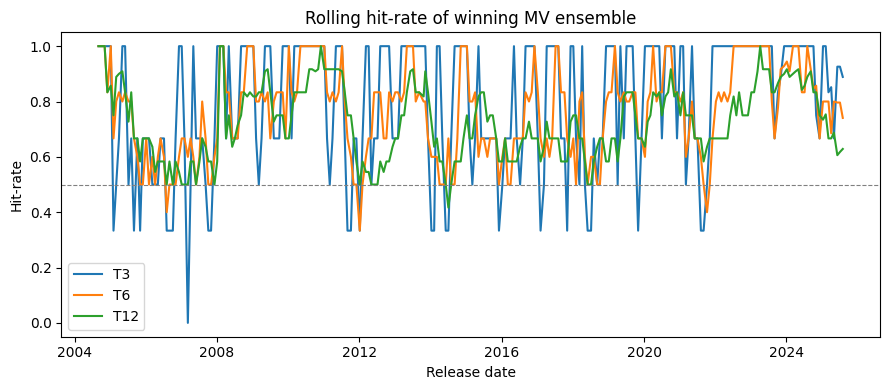

In [14]:
# =============================================================
#  Dynamic majority-vote ensembles, baseline benchmark
# =============================================================

# ---------- hyperparameters & regimes -----------------------
WINDOWS    = {3: "T3", 6: "T6", 12: "T12"}
K_SET      = (3, 5)
ALPHA      = 0.10
LAMBDA_AC  = 1.0

REGIMES = {
    "2003-06 to 2007-12 (pre-GFC)"               : (pd.Timestamp("2003-06-01"),
                                                    pd.Timestamp("2007-12-31")),
    "2008-01 to 2009-12 (GFC)"                   : (pd.Timestamp("2008-01-01"),
                                                    pd.Timestamp("2009-12-31")),
    "2010-01-2014-12 (early-expansion, post GFC)": (pd.Timestamp("2010-01-01"),
                                                    pd.Timestamp("2014-12-31")),
    "2015-01-2019-12 (late-expansion, post GFC)" : (pd.Timestamp("2015-01-01"),
                                                    pd.Timestamp("2019-12-31")),
    "2020-01 to 2022-12 (COVID)"                 : (pd.Timestamp("2020-01-01"),
                                                    pd.Timestamp("2022-12-31")),
    "2023-01 to present (post-COVID)"            : (pd.Timestamp("2023-01-01"),
                                                    pd.Timestamp.today()),
}

# ---------- helper functions ---------------------------------
def _spec_metrics(oos: pd.DataFrame) -> dict:
    """Basic directional stats for one spec up to a cut-off date (oos already filtered)."""
    df = oos.dropna(subset=["actual"]).copy()
    if df.empty:
        return {"obs": 0, "rmse": np.nan, "hr": np.nan,
                "dm_p": np.nan, "pt_p": np.nan}

    df["smart_err"]  = df["smart"]  - df["actual"]
    df["median_err"] = df["median"] - df["actual"]
    df["pred_dir"]   = (df["smart"] > df["median"]).astype(int)
    df["actual_dir"] = (df["actual"] > df["median"]).astype(int)

    obs  = len(df)
    rmse = np.sqrt((df["smart_err"]**2).mean())
    hr   = (df["pred_dir"] == df["actual_dir"]).mean()

    diff = df["smart_err"]**2 - df["median_err"]**2
    dm_p = (1.0 if diff.std(ddof=1) == 0 else
            2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs)))))

    p1, p2 = df["pred_dir"].mean(), df["actual_dir"].mean()
    denom  = p1*p2*(1-p1)*(1-p2)
    pt_p   = 1.0 if denom == 0 else \
             2*(1 - stats.norm.cdf(abs(((df["pred_dir"] & df["actual_dir"]).mean()-p1*p2) /
                                        math.sqrt(denom/obs))))
    return {"obs": obs, "rmse": rmse, "hr": hr, "dm_p": dm_p, "pt_p": pt_p}

def _candidate_pool(stats_df: pd.DataFrame) -> list[str]:
    """Specs that win lowest-RMSE / highest-HR / robust filters within the cut-off date."""
    chosen = set()
    for (_, _), grp in stats_df.groupby(["model", "panel"]):
        grp = grp[grp["obs"] > 0]
        if grp.empty:
            continue
        chosen.add(grp.loc[grp["rmse"].idxmin(), "spec_id"])
        chosen.add(grp.loc[grp["hr"  ].idxmax(), "spec_id"])
        rob = grp[(grp["dm_p"] < ALPHA) & (grp["pt_p"] < ALPHA)]
        if not rob.empty:
            chosen.add(rob.loc[rob["rmse"].idxmin(), "spec_id"])
    return sorted(chosen)

# --- OOS look-ups --------------------------------------------
oos_full = {}
for mdl, pnl_map in oos_maps.items():
    oos_full.update(pnl_map.get("Full", {}))

def merged_oos(combo: tuple[str, ...]) -> pd.DataFrame:
    """Merge members; keep individual smart forecasts for majority voting."""
    dfs = []
    for i, sid in enumerate(combo):
        tmp = (oos_full[sid][["date", "smart", "median", "actual"]]
               .rename(columns={"smart":  f"smart_{i}",
                                "median": f"median_{i}",
                                "actual": f"actual_{i}"}))
        dfs.append(tmp)
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on="date")
    smart_cols = [c for c in df.columns if c.startswith("smart_")]
    df["ens"]    = df[smart_cols].mean(axis=1)
    df["median"] = df["median_0"]
    df["actual"] = df["actual_0"]
    return df[["date", "ens", "median", "actual", *smart_cols]]

_combo_cache: dict[tuple[str, ...], pd.DataFrame] = {}
def _merged_oos_cached(combo: tuple[str, ...]) -> pd.DataFrame:
    if combo not in _combo_cache:
        _combo_cache[combo] = merged_oos(combo)
    return _combo_cache[combo]

def _mv_hitrate(df: pd.DataFrame) -> float:
    smart_cols = [c for c in df.columns if c.startswith("smart_")]
    votes      = (df[smart_cols].gt(df["median"], axis=0)).sum(axis=1)
    return (votes > len(smart_cols)/2).eq(df["actual"] > df["median"]).mean()

def _combo_hitrate(combo, t_cut, window):
    df = _merged_oos_cached(combo)
    sub = df[(df["date"] >= t_cut - pd.DateOffset(months=window)) &
             (df["date"] <  t_cut) &
             df["actual"].notna()]
    return _mv_hitrate(sub), len(sub)

def _window_rmse(combo, t_cut, window):
    df = _merged_oos_cached(combo)
    sub = df[(df["date"] >= t_cut - pd.DateOffset(months=window)) &
             (df["date"] <  t_cut) &
             df["actual"].notna()]
    return np.inf if sub.empty else np.sqrt(((sub["ens"] - sub["actual"])**2).mean())

def _choose_best_combo(pool, t_cut, window):
    best_combo, best_hr, best_rmse = None, -1.0, np.inf
    for k in K_SET:
        if len(pool) < k:
            continue
        for combo in itertools.combinations(pool, k):
            hr, _ = _combo_hitrate(combo, t_cut, window)
            if math.isnan(hr):
                continue
            if hr > best_hr:
                best_combo, best_hr = combo, hr
                best_rmse = _window_rmse(combo, t_cut, window)
            elif hr == best_hr:
                rmse = _window_rmse(combo, t_cut, window)
                if rmse < best_rmse or (rmse == best_rmse and combo < best_combo):
                    best_combo, best_rmse = combo, rmse
    return best_combo, best_hr

def _ensemble_direction(combo, t_date):
    df = _merged_oos_cached(combo)
    row = df[df["date"] == t_date].iloc[0]
    return int(row["ens"] > row["median"])

def _actual_direction(sample_oos, t_date):
    row = sample_oos[sample_oos["date"] == t_date].iloc[0]
    return int(row["actual"] > row["median"])

def stratified_table(df_preds: pd.DataFrame) -> pd.DataFrame:
    rows = []
    df = df_preds.copy()
    df["pred_dir"]   = df["pred_dir"].astype(int)
    df["actual_dir"] = df["actual_dir"].astype(int)
    for lbl, (s, e) in REGIMES.items():
        sub = df[(df["date"] >= s) & (df["date"] <= e)]
        if sub.empty:
            continue
        hits = (sub["pred_dir"] == sub["actual_dir"]).sum()
        n    = len(sub)
        hr   = hits / n
        binom_p = stats.binomtest(hits, n, .5).pvalue
        p1, p2  = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        denom   = p1*p2*(1-p1)*(1-p2)
        pt_p = (1.0 if denom == 0 else
                2*(1 - stats.norm.cdf(abs(((sub["pred_dir"] & sub["actual_dir"]).mean()-p1*p2) /
                                           math.sqrt(denom/n)))))
        rows.append({"Regime": lbl, "Obs": n,
                     "HitRate": hr, "Binom_p": binom_p, "PT_p": pt_p})
    return pd.DataFrame(rows)

def _ac_score(overall_hr, reg_hits, lam=LAMBDA_AC):
    return np.nan if len(reg_hits) < 2 or math.isnan(overall_hr) else \
           (1 - overall_hr) + lam * np.std(reg_hits, ddof=1)

def _strat_no_trailing(df_preds: pd.DataFrame) -> pd.DataFrame:
    base = stratified_table(df_preds)
    return base[~base["Regime"].str.startswith("Trailing")].reset_index(drop=True)

# -------------------------------------------------------------
# Rolling evaluation (dynamic warm-up)
# -------------------------------------------------------------
TAG_BASE = ["T3", "T6", "T12"]
records   = {tag: [] for tag in TAG_BASE + ["bestHR", "nestedEnsemble"]}
sel_hr_ts = {tag: [] for tag in TAG_BASE}

cum_hits, cum_obs = defaultdict(int), defaultdict(int)

all_dates = sorted({pd.to_datetime(d)
                    for mdl in oos_maps.values()
                    for pnl in mdl.values()
                    for o   in pnl.values()
                    for d   in o["date"].unique()})

sample_oos_any = next(iter(oos_maps[next(iter(oos_maps))]["Full"].values()))

for t in tqdm(all_dates, desc="Rolling evaluation", unit="month"):
    # per-spec metrics up to t-1
    rows = []
    for m_id, pnl_map in oos_maps.items():
        for p_name, specs in pnl_map.items():
            for sid, oos in specs.items():
                met = _spec_metrics(oos[oos["date"] < t])
                met.update(model=m_id, panel=p_name, spec_id=sid)
                rows.append(met)
    stats_df = pd.DataFrame(rows)
    if stats_df["obs"].max() < 12:
        continue

    pool = _candidate_pool(stats_df)
    if len(pool) < 3:
        continue

    best_combo, win_hr = {}, {}
    for W in WINDOWS:
        combo, hr = _choose_best_combo(pool, t, W)
        if combo is not None:
            tag = WINDOWS[W]
            best_combo[tag] = combo
            win_hr[tag]     = hr

    if not set(TAG_BASE).issubset(best_combo):
        continue

    # bestHR & nestedEnsemble
    tag_max = max(TAG_BASE, key=lambda k: win_hr[k])
    best_combo["bestHR"] = best_combo[tag_max]

    votes = [_ensemble_direction(best_combo[tag], t) for tag in TAG_BASE]
    majority = int(sum(votes) > 1)
    best_combo["nestedEnsemble"] = ("NEST",)
    _combo_cache[("NEST",)] = pd.DataFrame()

    actual_known = pd.notna(
        sample_oos_any.loc[sample_oos_any["date"] == t, "actual"].iloc[0])

    for tag, combo in best_combo.items():
        pred_dir = majority if tag == "nestedEnsemble" else _ensemble_direction(combo, t)
        rec = {"date": t, "pred_dir": pred_dir}
        if actual_known:
            rec["actual_dir"] = _actual_direction(sample_oos_any, t)
            rec["hit"] = int(rec["pred_dir"] == rec["actual_dir"])
        records[tag].append(rec)

        if tag in sel_hr_ts:
            sel_hr_ts[tag].append((t, win_hr[tag]))

        if tag in TAG_BASE and actual_known:
            cum_hits[combo] += rec["hit"]
            cum_obs [combo] += 1

# -------------------------------------------------------------
# Baseline (average individual economist hit-rate)
# -------------------------------------------------------------
eval_dates = {r["date"] for r in records["T3"] if "hit" in r}

baseline_df = (df_full
               .dropna(subset=["actual"])
               .loc[lambda d: d["release_date"].isin(eval_dates)]
               .copy())

baseline_df["pred_dir"]   = (baseline_df["forecast"] > baseline_df["median_forecast"]).astype(int)
baseline_df["actual_dir"] = (baseline_df["actual"]   > baseline_df["median_forecast"]).astype(int)
baseline_df["hit"]        = (baseline_df["pred_dir"] == baseline_df["actual_dir"]).astype(int)

def _baseline_strat(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for lbl, (s, e) in REGIMES.items():
        sub = df[(df["release_date"] >= s) & (df["release_date"] <= e)]
        if sub.empty:
            continue
        hits = sub["hit"].sum()
        n    = len(sub)
        hr   = hits / n
        binom_p = stats.binomtest(hits, n, .5).pvalue
        p1, p2  = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        denom   = p1*p2*(1-p1)*(1-p2)
        pt_p = (1.0 if denom == 0 else
                2*(1 - stats.norm.cdf(abs(((sub["pred_dir"] & sub["actual_dir"]).mean()-p1*p2) /
                                           math.sqrt(denom/n)))))
        rows.append({"Regime": lbl, "Obs": n,
                     "HitRate": hr, "Binom_p": binom_p, "PT_p": pt_p})
    return pd.DataFrame(rows)

baseline_overall_hr = baseline_df["hit"].mean() if not baseline_df.empty else np.nan
baseline_strat      = _baseline_strat(baseline_df)

# -------------------------------------------------------------
# Summaries & diagnostics  (incl. Baseline)
# -------------------------------------------------------------
summary_rows, strat_tables = [], {}
for tag, recs in records.items():
    dfp = (pd.DataFrame(recs)
             .dropna(subset=["hit"])
             .assign(pred_dir=lambda d: d["pred_dir"].astype(int),
                     actual_dir=lambda d: d["actual_dir"].astype(int)))
    ov_hr = dfp["hit"].mean() if not dfp.empty else np.nan
    strat = _strat_no_trailing(dfp) if not dfp.empty else pd.DataFrame()
    ac    = _ac_score(ov_hr, strat["HitRate"], LAMBDA_AC) if not strat.empty else np.nan
    if not strat.empty:
        strat_tables[tag] = strat
    summary_rows.append({"Method": tag, "Obs": len(dfp),
                         "HitRate": ov_hr, f"ACλ={LAMBDA_AC}": ac})

summary_rows.append({"Method": "Baseline",
                     "Obs": len(baseline_df),
                     "HitRate": baseline_overall_hr,
                     f"ACλ={LAMBDA_AC}": _ac_score(baseline_overall_hr,
                                                   baseline_strat["HitRate"],
                                                   LAMBDA_AC)})
strat_tables["Baseline"] = baseline_strat

# ---------- console output -----------------------------------
pd.set_option("display.float_format", "{:.3f}".format)

for tag, tbl in strat_tables.items():
    print(f"\n--- Stratified diagnostics for {tag} ---")
    print(tbl.to_string(index=False, float_format=lambda x: f"{x:0.3f}"))
    ac_val = next(r[f"ACλ={LAMBDA_AC}"] for r in summary_rows if r["Method"] == tag)
    print(f"Accuracy × Consistency (λ = {LAMBDA_AC}):  {ac_val:0.3f}\n")

print("\n=== Dynamic robust-ensemble back-test summary ===")
print(pd.DataFrame(summary_rows)
        .sort_values("Method")
        .to_string(index=False, float_format=lambda x: f"{x:0.3f}"))


# HR evolution plot of winning ensemble for each window 
plt.figure(figsize=(9, 4))
for tag in TAG_BASE:
    if sel_hr_ts[tag]:
        dates, hrs = zip(*sorted(sel_hr_ts[tag], key=lambda x: x[0]))
        plt.plot(dates, hrs, label=tag)
plt.axhline(.5, ls="--", lw=.8, color="grey")
plt.title("Rolling hit-rate of winning MV ensemble")
plt.ylabel("Hit-rate")
plt.xlabel("Release date")
plt.legend()
plt.tight_layout()
plt.show()

## 2 Distributional forecasting

We deploy the following distributional forecasting methods to quantify forecast uncertainty
1. Student-t fitted to past errors
2. t-GARCH: Rolling-36 GARCH(1,1) with Student-t innovations 
3. Gaussian Mixture Models
4. Bayesian Model Averaging

### 2.1 Student-t error bands

In [15]:
# settings
ROLL_WIN   = 36
MIN_TRAIN  = 36
LEVELS     = np.array([.50,.60,.70,.80,.90,.95])
BETA_BASE  = 0.0
BETA_CRIS  = 0.80
PCTL_THRES = 0.95
LAMBDA     = 1.0
PANELS     = {"COVID": df, "Full": df_full}

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

ci_half = lambda lvl, df_, sig: st.t.ppf(1-(1-lvl)/2, df=df_)*sig

# ---------------------------------------------------------------------
# Candidate spec grid  (name, window_type, use_mu_shift)
# CrisisAdj toggled later so we get 9 total variants
# ---------------------------------------------------------------------
SPEC_BASE = [
    ("Exp_noShift" , "expanding", False),
    ("Roll36_noShift", "rolling", False),
    ("Roll36_plusMu" , "rolling", True ),
]

# Build a reverse‑lookup to reconstruct settings from a tag --------
spec_params = {}
for nm, wt, um in SPEC_BASE:
    for crisis in (False, True):
        tag = f"{nm}_{'Yes' if crisis else 'No'}"
        spec_params[tag] = dict(name=nm, wtype=wt,
                                use_mu=um, crisis=crisis)

# =====================================================================
# BACKTEST  (both panels, all tags)
# =====================================================================
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    # per‑release aggregates ------------------------------------------
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast","median"),
                      actual    =("actual","first"),
                      spread    =("forecast","std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel["err"] = rel["median_fc"] - rel["actual"]
    eval_df = rel[rel["actual"].notna()].reset_index(drop=True)

    for nm, wtype, use_mu in SPEC_BASE:
        for crisis in (False, True):
            tag   = f"{nm}_{'Yes' if crisis else 'No'}"
            hits  = defaultdict(int);  totN = 0

            for i in tqdm(range(MIN_TRAIN, len(eval_df)),
                          desc=f"{p_label} | {tag}", leave=False):

                # training window -----------------------------------
                if wtype == "expanding":
                    errs = eval_df.loc[:i-1, "err"].values
                    sprd = eval_df.loc[:i-1, "spread"].values
                else:
                    if i < ROLL_WIN:  continue
                    errs = eval_df.loc[i-ROLL_WIN:i-1, "err"].values
                    sprd = eval_df.loc[i-ROLL_WIN:i-1, "spread"].values

                nu, mu, sig = st.t.fit(errs)

                pt      = eval_df.at[i, "median_fc"]
                act     = eval_df.at[i, "actual"]
                sp_t    = eval_df.at[i, "spread"]

                # crisis multiplier -------------------------------
                if crisis:
                    med_sp = np.median(sprd)
                    pct    = (sprd < sp_t).mean()
                    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
                    mult   = (sp_t/med_sp)**beta
                else:
                    mult   = 1.0

                centre = pt + (mu if use_mu else 0.0)

                for L in LEVELS:
                    h = ci_half(L, nu, sig)*mult
                    if centre-h <= act <= centre+h:
                        hits[L] += 1
                totN += 1

            if totN == 0:  continue
            emp = np.array([hits[L]/totN for L in LEVELS])
            for L, e in zip(LEVELS, emp):
                cov_rows.append(dict(Panel=p_label, Spec=tag,
                                     Nominal=L, Empirical=e))
            gap_rows.append(dict(Panel=p_label, Spec=tag,
                                 AvgAbsGap=float(np.abs(emp-LEVELS).mean())))

# ------------ tidy back‑test tables ---------------------------
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel","Spec"])
             .sort_index())

print("\n=== Back‑test coverage (Student‑t) ===")
print(cov_tbl)
print("\nMean‑absolute coverage gap (lower = better):")
print(gap_tbl)

# =====================================================================
# pick best spec
# =====================================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag = best_row.name         # MultiIndex -> tag str
best_cfg = spec_params[best_tag]

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag          : {best_tag}")
print(f"  Window type  : {best_cfg['wtype']}")
print(f"  μ‑shift      : {best_cfg['use_mu']}")
print(f"  CrisisAdj    : {best_cfg['crisis']}")
print(f"  AvgAbsGap    : {best_row['AvgAbsGap']:.4f}")

# =====================================================================
# helper to compute half‑width multiplier  (crisis / no‑crisis)
# =====================================================================
def crisis_mult(sp_hist, sp_t, crisis_flag):
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# =====================================================================
# STRATIFIED (best spec)
# =====================================================================
print("\n=== Stratified 4‑block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "median"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    idx_eval = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(idx_eval, 4)

    g_hits = defaultdict(int); g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int); tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            # training window per spec ---------------------------
            if best_cfg['wtype'] == "expanding":
                err_h = rel.loc[:j-1, "err"].values
                sp_h  = rel.loc[:j-1, "spread"].values
            else:                                           # rolling‑36
                if j < ROLL_WIN:  continue
                err_h = rel.loc[j-ROLL_WIN:j-1, "err"].values
                sp_h  = rel.loc[j-ROLL_WIN:j-1, "spread"].values

            nu, mu, sig = st.t.fit(err_h)

            centre  = rel.at[j, "median_fc"] + (mu if best_cfg['use_mu'] else 0.0)
            actual  = rel.at[j, "actual"]
            sp_t    = rel.at[j, "spread"]
            mult    = crisis_mult(sp_h, sp_t, best_cfg['crisis'])

            for L in LEVELS:
                h = ci_half(L, nu, sig) * mult
                hit = int(centre - h <= actual <= centre + h)
                hits[L]   += hit
                g_hits[L] += hit
            tot   += 1
            g_tot += 1

        emp = np.array([hits[L] / tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block=b_no,
                              Start=st_dt, End=en_dt,
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp)])
        gap_rows.append(dict(Panel=p_label, Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp - LEVELS).mean())))

    # global “All” row
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows.extend([dict(Panel=p_label, Block="All",
                          Start=rel.iloc[0]["release_date"].date(),
                          End  =rel.iloc[-1]["release_date"].date(),
                          Nominal=L, Empirical=e)
                     for L, e in zip(LEVELS, emp_all)])
    gap_rows.append(dict(Panel=p_label, Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End  =rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

# ---------- tidy + print ----------
cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel", "Block", "Start", "End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel", "Block", "Start", "End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean‑absolute gap by block:")
print(gap_tbl_blk)

# ---------- ACCURACY × CONSISTENCY score ----------
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1, 2, 3, 4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": mag_all + LAMBDA * sd_blk})

score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy × Consistency summary (lower = better):")
print(score_tbl)


# live CI (if applicable)
print("\n=== Live CI using best spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row      = unreleased.iloc[-1]
    t_date   = row["release_date"].date()
    pt_med   = row["median_forecast"]
    sp_t     = row["forecast"].std()

    # history window
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast","first"),
                 actual    =("actual","first"),
                 spread    =("forecast","std"))
            .tail(ROLL_WIN if best_cfg['wtype']=="rolling" else None))

    if len(hist) < MIN_TRAIN:
        print(f"{p_label}: not enough history for live CI.")
        continue

    hist["err"] = hist["median_fc"] - hist["actual"]
    nu, mu, sig = st.t.fit(hist["err"].values)

    centre = pt_med + (mu if best_cfg['use_mu'] else 0.0)
    mult   = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L in (.50,.60,.70,.80,.90,.95):
        h = ci_half(L, nu, sig)*mult
        print(f"  {int(L*100)}% band : [{centre-h:,.0f} , {centre+h:,.0f}] k")
    print()


COVID | Exp_noShift_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Exp_noShift_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_noShift_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_noShift_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_plusMu_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_plusMu_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

Full | Exp_noShift_No:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Exp_noShift_Yes:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_noShift_No:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_noShift_Yes:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_plusMu_No:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_plusMu_Yes:   0%|          | 0/230 [00:00<?, ?it/s]


=== Back‑test coverage (Student‑t) ===
Nominal                   0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                        
COVID Exp_noShift_No      0.562  0.639  0.706  0.840  0.933  0.959
      Exp_noShift_Yes     0.577  0.649  0.716  0.851  0.933  0.964
      Roll36_noShift_No   0.510  0.593  0.675  0.773  0.897  0.948
      Roll36_noShift_Yes  0.526  0.619  0.696  0.784  0.907  0.954
      Roll36_plusMu_No    0.495  0.577  0.655  0.742  0.871  0.938
      Roll36_plusMu_Yes   0.505  0.603  0.670  0.768  0.881  0.943
Full  Exp_noShift_No      0.496  0.578  0.657  0.787  0.878  0.926
      Exp_noShift_Yes     0.543  0.622  0.709  0.839  0.922  0.961
      Roll36_noShift_No   0.504  0.587  0.674  0.778  0.909  0.943
      Roll36_noShift_Yes  0.526  0.613  0.696  0.796  0.926  0.961
      Roll36_plusMu_No    0.470  0.565  0.643  0.770  0.887  0.943
      Roll36_plusMu_Yes   0.487  0.591  0.661  0.796  0.904  0.961

Mean‑absolute coverag

COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk2:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/57 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/57 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
COVID 1     2006-06-02 2010-06-04  0.551  0.592  0.673  0.735  0.898  0.959
      2     2010-07-02 2014-07-03  0.531  0.592  0.673  0.796  0.980  0.980
      3     2014-08-01 2018-07-06  0.500  0.667  0.708  0.771  0.854  0.938
      4     2018-08-03 2025-07-03  0.458  0.521  0.646  0.792  0.854  0.917
      All   2003-06-06 2025-07-03  0.510  0.593  0.675  0.773  0.897  0.948
Full  1     2006-06-02 2011-03-04  0.517  0.569  0.655  0.707  0.914  0.966
      2     2011-04-01 2016-01-08  0.552  0.603  0.672  0.810  0.931  0.966
      3     2016-02-05 2020-10-02  0.404  0.561  0.649  0.684  0.807  0.842
      4     2020-11-06 2025-07-03  0.544  0.614  0.719  0.912  0.982  1.000
      All   2003-06-06 2025-07-03  0.504  0.587  0.674  0.778  0.909  0.943

Mean‑absolute gap by block:
                                   AvgAbsGap
Panel Block St

### 2.2 GARCH(1,1)

In [16]:
ROLL_WIN   = 36                       # rolling window length
MIN_TRAIN  = 36                       # first release scored
LEVELS     = np.array([.50,.60,.70,.80,.90,.95])
BETA_BASE  = 0.0                      # crisis spread‑elasticity
BETA_CRIS  = 0.80
PCTL_THRES = 0.95                     # top‑5 % spread ⇒ crisis
LAMBDA     = 1.0                      # weight for consistency score
SCALE      = 100.0                  # k‑jobs → hundreds
PANELS     = {"COVID": df, "Full": df_full}

# ───────── helpers ─────────────────────────────────────────────
def ci_half(level: float, nu: float, sigma: float) -> float:
    """Half‑width of two‑sided Student‑t interval (ν = nu, σ = sigma)."""
    return st.t.ppf(1 - (1 - level) / 2, df=nu) * sigma

def garch_one_step(rescaled_errs: np.ndarray):
    """
    Fit Constant‑Mean + GARCH(1,1)‑t on *rescaled* errors and return
    one‑step‑ahead (ν, σ̂ₜ₊₁, μ̂ₜ₊₁) in ORIGINAL units.
    """
    mdl = ConstantMean(rescaled_errs, rescale=False)
    mdl.volatility   = GARCH(1, 1)
    mdl.distribution = StudentsT()
    res = mdl.fit(disp="off")
    fc  = res.forecast(horizon=1)
    mu  = fc.mean.iloc[-1, 0] * SCALE
    sig = math.sqrt(fc.variance.iloc[-1, 0]) * SCALE
    nu  = res.params["nu"]
    return nu, sig, mu

def crisis_mult(sp_hist, sp_t, crisis_flag: bool) -> float:
    """Spread‑based crisis multiplier (1 if crisis_flag is False)."""
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# ================================================================
# BACK‑TEST – both panels, two specs (NoAdj / CrisisAdj)
# ================================================================
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    # ─── per‑release aggregates ────────────────────────────────
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    for crisis_flag in (False, True):
        tag   = f"GARCH_{'CrisisAdj' if crisis_flag else 'NoAdj'}"
        hits  = defaultdict(int); totN = 0

        for i in tqdm(range(MIN_TRAIN, len(rel)),
                      desc=f"{p_label} | {tag}", leave=False):
            # ─── training window ────────────────────────────────
            start = max(0, i - ROLL_WIN) 
            errs  = rel.loc[start:i-1, "err"].values / SCALE
            nu, sig_fc, mu_fc = garch_one_step(errs)

            centre   = rel.at[i, "median_fc"] + mu_fc   # μ‑shift always on
            actual   = rel.at[i, "actual"]
            sp_t     = rel.at[i, "spread"]
            mult     = crisis_mult(rel.loc[start:i-1, "spread"].values,
                                   sp_t, crisis_flag)

            for L in LEVELS:
                if centre - ci_half(L, nu, sig_fc)*mult <= actual <= \
                   centre + ci_half(L, nu, sig_fc)*mult:
                    hits[L] += 1
            totN += 1

        # ─── store results ─────────────────────────────────────
        emp_vec = np.array([hits[L] / totN for L in LEVELS])
        for L, e in zip(LEVELS, emp_vec):
            cov_rows.append(dict(Panel=p_label, Spec=tag,
                                 Nominal=L, Empirical=e))
        gap_rows.append(dict(Panel=p_label, Spec=tag,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

# ─── tidy & print back‑test tables ─────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back‑test coverage (GARCH(1,1)‑t) ===")
print(cov_tbl)
print("\nMean‑absolute coverage gap (lower = better):")
print(gap_tbl)

# ================================================================
# Pick best spec on FULL panel
# ================================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag  = best_row.name
best_cfg  = dict(crisis = "CrisisAdj" in best_tag)

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# ================================================================
# STRATIFIED ANALYSIS  (using best spec)
# ================================================================
print("\n=== Stratified 4‑block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    idx_eval = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(idx_eval, 4)

    g_hits = defaultdict(int); g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int); tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            start = max(0, j - ROLL_WIN)
            errs  = rel.loc[start:j-1, "err"].values / SCALE
            nu, sig_fc, mu_fc = garch_one_step(errs)

            centre = rel.at[j, "median_fc"] + mu_fc
            actual = rel.at[j, "actual"]
            sp_t   = rel.at[j, "spread"]
            mult   = crisis_mult(rel.loc[start:j-1, "spread"].values,
                                 sp_t, best_cfg['crisis'])

            for L in LEVELS:
                hit = centre - ci_half(L, nu, sig_fc)*mult <= actual <= \
                      centre + ci_half(L, nu, sig_fc)*mult
                hits[L]   += hit
                g_hits[L] += hit
            tot += 1
            g_tot += 1

        emp_vec = np.array([hits[L] / tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block=b_no,
                              Start=st_dt, End=en_dt,
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp_vec)])
        gap_rows.append(dict(Panel=p_label, Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

    # global “All”
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows.extend([dict(Panel=p_label, Block="All",
                          Start=rel.iloc[0]["release_date"].date(),
                          End  =rel.iloc[-1]["release_date"].date(),
                          Nominal=L, Empirical=e)
                     for L, e in zip(LEVELS, emp_all)])
    gap_rows.append(dict(Panel=p_label, Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End  =rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel","Block","Start","End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel","Block","Start","End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean‑absolute gap by block:")
print(gap_tbl_blk)

# ─── Accuracy × Consistency score ──────────────────────────────
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"]=="All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": mag_all + LAMBDA*sd_blk})
score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy × Consistency summary (lower = better):")
print(score_tbl)

# ================================================================
# LIVE CI for unreleased month (best spec)
# ================================================================
print("\n=== Live CI using best GARCH spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_forecast"]
    sp_t   = row["forecast"].std()

    # history window
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast","first"),
                 actual    =("actual","first"),
                 spread    =("forecast","std"))
            .tail(ROLL_WIN))
    if len(hist) < MIN_TRAIN:
        print(f"{p_label}: not enough history for live CI.")
        continue

    hist["err"] = hist["median_fc"] - hist["actual"]
    nu, sig_fc, mu_fc = garch_one_step(hist["err"].values / SCALE)

    centre = pt_med + mu_fc
    mult   = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L in LEVELS:
        h = ci_half(L, nu, sig_fc) * mult
        print(f"  {int(L*100)}% band : [{centre-h:,.0f} , {centre+h:,.0f}] k")
    print()


COVID | GARCH_NoAdj:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | GARCH_CrisisAdj:   0%|          | 0/194 [00:00<?, ?it/s]

Full | GARCH_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

Full | GARCH_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]


=== Back‑test coverage (GARCH(1,1)‑t) ===
Nominal                0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                     
COVID GARCH_CrisisAdj  0.500  0.598  0.675  0.778  0.897  0.938
      GARCH_NoAdj      0.485  0.588  0.665  0.773  0.887  0.933
Full  GARCH_CrisisAdj  0.513  0.622  0.696  0.800  0.913  0.943
      GARCH_NoAdj      0.487  0.600  0.674  0.783  0.891  0.926

Mean‑absolute coverage gap (lower = better):
                       AvgAbsGap
Panel Spec                      
COVID GARCH_CrisisAdj      0.011
      GARCH_NoAdj          0.020
Full  GARCH_CrisisAdj      0.010
      GARCH_NoAdj          0.015

>>> Best spec on FULL panel <<<
  Tag        : GARCH_CrisisAdj
  CrisisAdj  : True
  AvgAbsGap  : 0.0098

=== Stratified 4‑block results (best spec) ===


COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk2:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/57 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/57 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
COVID 1     2006-06-02 2010-06-04  0.469  0.531  0.633  0.755  0.857  0.898
      2     2010-07-02 2014-07-03  0.490  0.633  0.653  0.776  0.939  0.959
      3     2014-08-01 2018-07-06  0.521  0.646  0.708  0.792  0.896  0.958
      4     2018-08-03 2025-07-03  0.521  0.583  0.708  0.792  0.896  0.938
      All   2003-06-06 2025-07-03  0.500  0.598  0.675  0.778  0.897  0.938
Full  1     2006-06-02 2011-03-04  0.448  0.517  0.621  0.759  0.862  0.914
      2     2011-04-01 2016-01-08  0.500  0.638  0.655  0.759  0.914  0.948
      3     2016-02-05 2020-10-02  0.509  0.614  0.702  0.789  0.912  0.947
      4     2020-11-06 2025-07-03  0.596  0.719  0.807  0.895  0.965  0.965
      All   2003-06-06 2025-07-03  0.513  0.622  0.696  0.800  0.913  0.943

Mean‑absolute gap by block:
                                   AvgAbsGap
Panel Block St

### 2.3 Gaussian Mixture Model

- Prep. series of median residuals 
- Fit a GMM to the chosen window (either trailing 36 releases or full history if expanding window)
- For k = 1...4, we fit a GaussianMixture with full covariance. k = 1: single normal. k > 1: skew + fat tails captured through normal mixture. 
- Select optimal model (hyperparam *k*) with BIC 
- Monte Carlo sample 100k errors. Extract error quantiles to give lower/upper cutoffs
- Center band on median forecast for confidence interval (with/without crisis adjustment) 

In [17]:
# ───────── global settings ─────────────────────────────────────
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(7)

ROLL_WIN    = 36                       # rolling‑window length
MIN_TRAIN   = 36                       # first release scored
LEVELS      = np.array([.50,.60,.70,.80,.90,.95])
BETA_BASE   = 0.0                      # crisis spread‑elasticity
BETA_CRIS   = 0.80
PCTL_THRES  = 0.95                     # top‑5 % spread ⇒ crisis
LAMBDA      = 1.0                      # weight for consistency score
N_SIMS      = 100_000                  # MC draws for quantiles
K_GRID      = range(1, 5)              # mixture sizes to try
PANELS      = {"COVID": df, "Full": df_full}

# ───────── helpers ─────────────────────────────────────────────
def best_gmm(errs: np.ndarray) -> GaussianMixture:
    """Fit k=1…4 GMMs; return model with the lowest BIC."""
    errs = errs.reshape(-1, 1)
    best, best_bic = None, math.inf
    for k in K_GRID:
        gm  = GaussianMixture(n_components=k, covariance_type="full",
                              reg_covar=1e-6, random_state=0).fit(errs)
        bic = gm.bic(errs)
        if bic < best_bic:
            best, best_bic = gm, bic
    return best

def mc_quantiles(gm: GaussianMixture, probs, n=N_SIMS):
    """Two‑sided quantiles of a fitted GMM via Monte‑Carlo sampling."""
    sims = gm.sample(n)[0].ravel()
    q_lo = np.quantile(sims, (1 - probs) / 2)           # negative
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)       # positive
    return q_lo, q_hi                                   # vectors

def crisis_mult(sp_hist, sp_t, crisis_flag: bool) -> float:
    """Spread‑based crisis multiplier (1 if crisis_flag is False)."""
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# =================================================================
# BACKTEST  –  Expanding vs Roll‑36  ×  (NoAdj / CrisisAdj)
# =================================================================
SPEC_GRID = [("Expanding", False), ("Expanding", True),
             ("Roll36",   False), ("Roll36",   True)]

cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    # ─── per‑release aggregates ────────────────────────────────
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    for wtype, crisis in SPEC_GRID:
        tag   = f"{wtype}_{'CrisisAdj' if crisis else 'NoAdj'}"
        hits  = defaultdict(int); totN = 0

        for i in tqdm(range(len(rel)), desc=f"{p_label} | {tag}", leave=False):
            # warm‑up check
            if (wtype == "Expanding" and i < MIN_TRAIN) or \
               (wtype == "Roll36"   and i < ROLL_WIN):
                continue

            # ─── training errors ───────────────────────────────
            if wtype == "Expanding":
                err_hist = rel.loc[:i-1, "err"].values
                sp_hist  = rel.loc[:i-1, "spread"].values
            else:  # Roll‑36
                err_hist = rel.loc[i-ROLL_WIN:i-1, "err"].values
                sp_hist  = rel.loc[i-ROLL_WIN:i-1, "spread"].values
            if err_hist.size < MIN_TRAIN:
                continue

            gmm        = best_gmm(err_hist)
            q_lo, q_hi = mc_quantiles(gmm, LEVELS)

            centre   = rel.at[i, "median_fc"]           # no μ‑shift in GMM (MC => implicitly centered at mu)
            actual   = rel.at[i, "actual"]
            spread_t = rel.at[i, "spread"]
            mult     = crisis_mult(sp_hist, spread_t, crisis)

            lo_band  = centre - mult * q_hi
            hi_band  = centre - mult * q_lo

            for L, lo, hi in zip(LEVELS, lo_band, hi_band):
                if lo <= actual <= hi:
                    hits[L] += 1
            totN += 1

        if totN == 0:  continue
        emp_vec = np.array([hits[L]/totN for L in LEVELS])
        for L, e in zip(LEVELS, emp_vec):
            cov_rows.append(dict(Panel=p_label, Spec=tag,
                                 Nominal=L, Empirical=e))
        gap_rows.append(dict(Panel=p_label, Spec=tag,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

# ─── tidy & print back‑test tables ─────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back‑test coverage (Gaussian‑Mixture) ===")
print(cov_tbl)
print("\nMean‑absolute coverage gap (lower = better):")
print(gap_tbl)

# =================================================================
# Pick best spec on FULL panel
# =================================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag = best_row.name
best_cfg = {
    "wtype"  : best_tag.split("_")[0],           # Expanding / Roll36
    "crisis" : "CrisisAdj" in best_tag
}

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  Window     : {best_cfg['wtype']}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# =================================================================
# STRATIFIED ANALYSIS  (on best spec)
# =================================================================
print("\n=== Stratified 4‑block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    idx_eval = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(idx_eval, 4)

    g_hits = defaultdict(int); g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int); tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            # training errors per spec ---------------------------
            if best_cfg['wtype'] == "Expanding":
                err_hist = rel.loc[:j-1, "err"].values
                sp_hist  = rel.loc[:j-1, "spread"].values
            else:
                if j < ROLL_WIN:  continue
                err_hist = rel.loc[j-ROLL_WIN:j-1, "err"].values
                sp_hist  = rel.loc[j-ROLL_WIN:j-1, "spread"].values
            if err_hist.size < MIN_TRAIN:
                continue

            gmm        = best_gmm(err_hist)
            q_lo, q_hi = mc_quantiles(gmm, LEVELS)

            centre = rel.at[j, "median_fc"]
            actual = rel.at[j, "actual"]
            sp_t   = rel.at[j, "spread"]
            mult   = crisis_mult(sp_hist, sp_t, best_cfg['crisis'])

            lo_band = centre - mult * q_hi
            hi_band = centre - mult * q_lo

            for L, lo, hi in zip(LEVELS, lo_band, hi_band):
                hit = lo <= actual <= hi
                hits[L]   += hit
                g_hits[L] += hit
            tot += 1
            g_tot += 1

        emp_vec = np.array([hits[L] / tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block=b_no,
                              Start=st_dt, End=en_dt,
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp_vec)])
        gap_rows.append(dict(Panel=p_label, Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

    # global “All” row
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows.extend([dict(Panel=p_label, Block="All",
                          Start=rel.iloc[0]["release_date"].date(),
                          End  =rel.iloc[-1]["release_date"].date(),
                          Nominal=L, Empirical=e)
                     for L, e in zip(LEVELS, emp_all)])
    gap_rows.append(dict(Panel=p_label, Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End  =rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel","Block","Start","End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel","Block","Start","End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean‑absolute gap by block:")
print(gap_tbl_blk)

# ─── Accuracy × Consistency score ──────────────────────────────
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"]=="All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": mag_all + LAMBDA*sd_blk})
score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy × Consistency summary (lower = better):")
print(score_tbl)

# =================================================================
# 4) LIVE CI for unreleased month (best spec)
# =================================================================
print("\n=== Live CI using best GMM spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_forecast"]
    sp_t   = row["forecast"].std()

    # history window ---------------------------------------------
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast","first"),
                 actual    =("actual","first"),
                 spread    =("forecast","std")))
    if best_cfg['wtype'] == "Roll36":
        hist = hist.tail(ROLL_WIN)
    if len(hist) < MIN_TRAIN:
        print(f"{p_label}: not enough history for live CI.")
        continue

    err_hist = (hist["median_fc"] - hist["actual"]).values
    gmm      = best_gmm(err_hist)
    q_lo, q_hi = mc_quantiles(gmm, LEVELS)

    mult   = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])
    lo_b   = pt_med - mult * q_hi
    hi_b   = pt_med - mult * q_lo

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L, lo, hi in zip(LEVELS, lo_b, hi_b):
        print(f"  {int(L*100)}% band : [{lo:,.0f} , {hi:,.0f}] k")
    print()


COVID | Expanding_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Expanding_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Expanding_NoAdj:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Expanding_CrisisAdj:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Roll36_NoAdj:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Roll36_CrisisAdj:   0%|          | 0/266 [00:00<?, ?it/s]


=== Back‑test coverage (Gaussian‑Mixture) ===
Nominal                    0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                         
COVID Expanding_CrisisAdj  0.582  0.634  0.732  0.861  0.943  0.959
      Expanding_NoAdj      0.572  0.619  0.716  0.861  0.938  0.954
      Roll36_CrisisAdj     0.526  0.639  0.711  0.778  0.907  0.948
      Roll36_NoAdj         0.505  0.624  0.696  0.768  0.897  0.943
Full  Expanding_CrisisAdj  0.543  0.609  0.730  0.835  0.913  0.948
      Expanding_NoAdj      0.500  0.557  0.674  0.791  0.870  0.900
      Roll36_CrisisAdj     0.535  0.622  0.709  0.787  0.913  0.957
      Roll36_NoAdj         0.513  0.604  0.691  0.770  0.896  0.939

Mean‑absolute coverage gap (lower = better):
                           AvgAbsGap
Panel Spec                          
COVID Expanding_CrisisAdj      0.044
      Expanding_NoAdj          0.035
      Roll36_CrisisAdj         0.018
      Roll36_NoAdj             0.012
Full 

COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk2:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/57 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/57 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
COVID 1     2006-06-02 2010-06-04  0.531  0.653  0.673  0.755  0.918  0.959
      2     2010-07-02 2014-07-03  0.531  0.612  0.694  0.776  0.980  0.980
      3     2014-08-01 2018-07-06  0.500  0.625  0.708  0.771  0.833  0.917
      4     2018-08-03 2025-07-03  0.458  0.604  0.708  0.771  0.854  0.917
      All   2003-06-06 2025-07-03  0.505  0.624  0.696  0.768  0.897  0.943
Full  1     2006-06-02 2011-03-04  0.500  0.621  0.655  0.741  0.931  0.966
      2     2011-04-01 2016-01-08  0.552  0.603  0.690  0.776  0.914  0.966
      3     2016-02-05 2020-10-02  0.404  0.544  0.649  0.684  0.789  0.842
      4     2020-11-06 2025-07-03  0.596  0.649  0.772  0.877  0.947  0.982
      All   2003-06-06 2025-07-03  0.513  0.604  0.691  0.770  0.896  0.939

Mean‑absolute gap by block:
                                   AvgAbsGap
Panel Block St

### 2.4 Bayesian Model Averaging
1. Compute error series for median forecast 
2. Per window, we fit two candidate errors models. 
    - Normal, fit via closed form MLE. Compute BIC
    - Student-t. Numerical MLE fit for params. Get BIC
3. Convert BICs from 2 models fit to Bayesian model weights via Occam weights. A lower BIC will yield a higher posterior probability. 
4. Similar to GMM: Monte Carlo 100,000 trials. Pick each error from either a normal and student-t distribution with probabilities determined by weights above. 
5. From simulated error bands, convert to forecast bands centered around median

In [18]:
# ---------- global settings -----------------------------------
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(7)                                 # reproducibility

ROLL_WIN   = 36                       # rolling window length
MIN_TRAIN  = 36                       # first release scored
LEVELS     = np.array([.50, .60, .70, .80, .90, .95])
BETA_BASE  = 0.0                      # crisis spread-elasticity
BETA_CRIS  = 0.80
PCTL_THRES = 0.95                     # top-5 % spread => crisis
LAMBDA     = 1.0                      # weight for consistency score
PANELS     = {"COVID": df, "Full": df_full}

N_SIMS     = 100_000                  # Monte-Carlo draws per fit
RNG        = np.random.default_rng(42)  # single RNG for whole cell

# ---------- helpers -------------------------------------------
def fit_normal(errs):
    mu  = np.mean(errs)
    sigma  = max(np.std(errs, ddof=1), 1e-6)      # guard sigma->0
    ll = np.sum(norm.logpdf(errs, loc=mu, scale=sigma))
    bic = 2 * np.log(len(errs)) - 2 * ll          # k = 2
    return {"name": "Normal", "mu": mu, "sigma": sigma, "nu": None,
            "ll": ll, "bic": bic}

def fit_student_t(errs):
    mu0, sigma0 = np.mean(errs), max(np.std(errs, ddof=1), 1e-6)
    def nll(p):
        nu, mu, sigma = p
        if nu <= 2 or sigma <= 1e-8:
            return np.inf
        return -np.sum(student_t.logpdf(errs, df=nu, loc=mu, scale=sigma))
    res = minimize(nll, (5.0, mu0, sigma0),
                   bounds=[(2.1, 100), (None, None), (1e-6, None)])
    nu, mu, sigma = res.x
    ll  = -res.fun
    bic = 3 * np.log(len(errs)) - 2 * ll          # k = 3
    return {"name": "Student-t", "mu": mu, "sigma": sigma, "nu": nu,
            "ll": ll, "bic": bic}

def bma_models(errs):
    """
    Fit Normal & Student-t; return list with weights ~ exp(-1/2 * deltaBIC).
    Guarantees the weights are finite and sum to 1.
    """
    m_n, m_t  = fit_normal(errs), fit_student_t(errs)
    bic_min   = min(m_n["bic"], m_t["bic"])
    w_n       = math.exp(-0.5 * (m_n["bic"] - bic_min))
    w_t       = math.exp(-0.5 * (m_t["bic"] - bic_min))
    z         = w_n + w_t
    if not np.isfinite(z) or z == 0:              # degenerate -> equal weights
        w_n, w_t, z = 0.5, 0.5, 1.0
    m_n["w"], m_t["w"] = w_n / z, w_t / z
    return [m_n, m_t]

def draw_bma(models, n_draws, *, rng):
    """Monte-Carlo draws from BMA mixture."""
    p = np.array([m["w"] for m in models])
    if np.isnan(p).any() or p.sum() == 0:         # final safety net
        p = np.full_like(p, 1 / len(p))
    picks = rng.choice(len(models), size=n_draws, p=p)
    draws = np.empty(n_draws)
    for idx, m in enumerate(models):
        m_n = np.sum(picks == idx)
        if m_n == 0:
            continue
        if m["name"] == "Normal":
            draws[picks == idx] = rng.normal(m["mu"], m["sigma"], size=m_n)
        else:                                     # Student-t
            draws[picks == idx] = (
                m["mu"] + m["sigma"] * rng.standard_t(m["nu"], size=m_n)
            )
    return draws

def mc_quantiles_bma(models, probs):
    sims = draw_bma(models, N_SIMS, rng=RNG)
    q_lo = np.quantile(sims, (1 - probs) / 2)
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)
    return q_lo, q_hi                             # vectors

def crisis_mult(sp_hist, sp_t, crisis_flag):
    """Return 1 if crisis_flag==False; else spread-based multiplier."""
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# ---------- spec grid  (window x crisis flag) -----------------
SPEC_GRID = [("Expanding", False), ("Expanding", True),
             ("Roll36",   False), ("Roll36",   True)]
spec_to_cfg = {f"{w}_{'CrisisAdj' if c else 'NoAdj'}":
               dict(window=w, crisis=c) for w, c in SPEC_GRID}

# ==============================================================
# BACK-TEST  (both panels, all tags)
# ==============================================================
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual", "first"),
                      spread    =("forecast", "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel.dropna(subset=["actual"]).reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    for window, crisis in SPEC_GRID:
        tag   = f"{window}_{'CrisisAdj' if crisis else 'NoAdj'}"
        hits  = defaultdict(int)
        totN  = 0

        for i in tqdm(range(len(rel)), desc=f"{p_label} | {tag}", leave=False):
            if (window == "Expanding" and i < MIN_TRAIN) or \
               (window == "Roll36"    and i < ROLL_WIN):
                continue
            start = 0 if window == "Expanding" else i - ROLL_WIN
            hist_errs = rel.loc[start:i-1, "err"].values
            if hist_errs.size < MIN_TRAIN or hist_errs.std() < 1e-8:
                continue                              # skip degenerate window
            models = bma_models(hist_errs)
            q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

            centre = rel.at[i, "median_fc"]           # no mu-shift
            mult   = crisis_mult(rel.loc[start:i-1, "spread"].values,
                                 rel.at[i, "spread"], crisis)
            band_lo = centre - mult * q_hi
            band_hi = centre - mult * q_lo
            actual  = rel.at[i, "actual"]

            for L, lo, hi in zip(LEVELS, band_lo, band_hi):
                if lo <= actual <= hi:
                    hits[L] += 1
            totN += 1

        if not totN:
            continue
        emp_vec = np.array([hits[L] / totN for L in LEVELS])
        for L, e in zip(LEVELS, emp_vec):
            cov_rows.append(dict(Panel=p_label, Spec=tag,
                                 Nominal=L, Empirical=e))
        gap_rows.append(dict(Panel=p_label, Spec=tag,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back-test coverage (BMA) ===")
print(cov_tbl)
print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)

# ==============================================================
# Pick best spec
# ==============================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag = best_row.name
best_cfg = spec_to_cfg[best_tag]

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  Window     : {best_cfg['window']}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# ==============================================================
# STRATIFIED ANALYSIS 
# ==============================================================
print("\n=== Stratified 4-block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual", "first"),
                      spread    =("forecast", "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel.dropna(subset=["actual"]).reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    eval_idx = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(eval_idx, 4)

    g_hits = defaultdict(int)
    g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int)
        tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            start = 0 if best_cfg['window'] == "Expanding" else j - ROLL_WIN
            if start < 0 or (j - start) < MIN_TRAIN:
                continue
            hist_errs = rel.loc[start:j-1, "err"].values
            if hist_errs.std() < 1e-8:
                continue
            models = bma_models(hist_errs)
            q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

            centre = rel.at[j, "median_fc"]
            mult   = crisis_mult(rel.loc[start:j-1, "spread"].values,
                                 rel.at[j, "spread"], best_cfg['crisis'])
            band_lo = centre - mult * q_hi
            band_hi = centre - mult * q_lo
            actual  = rel.at[j, "actual"]

            for L, lo, hi in zip(LEVELS, band_lo, band_hi):
                hit = lo <= actual <= hi
                hits[L]   += hit
                g_hits[L] += hit
            tot   += 1
            g_tot += 1

        if tot:
            emp_vec = np.array([hits[L] / tot for L in LEVELS])
            cov_rows.extend([dict(Panel=p_label, Block=b_no,
                                  Start=st_dt, End=en_dt,
                                  Nominal=L, Empirical=e)
                             for L, e in zip(LEVELS, emp_vec)])
            gap_rows.append(dict(Panel=p_label, Block=b_no,
                                 Start=st_dt, End=en_dt,
                                 AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

    if g_tot:
        emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block="All",
                              Start=rel.iloc[0]["release_date"].date(),
                              End  =rel.iloc[-1]["release_date"].date(),
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp_all)])
        gap_rows.append(dict(Panel=p_label, Block="All",
                             Start=rel.iloc[0]["release_date"].date(),
                             End  =rel.iloc[-1]["release_date"].date(),
                             AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel", "Block", "Start", "End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel", "Block", "Start", "End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean-absolute gap by block:")
print(gap_tbl_blk)

# --- Accuracy x Consistency score -----------------------------
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1, 2, 3, 4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(lambda={LAMBDA})": mag_all + LAMBDA * sd_blk})
score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy x Consistency summary (lower = better):")
print(score_tbl)

# ==============================================================
# LIVE CI for unreleased month (best spec)
# ==============================================================
print("\n=== Live CI using best BMA spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_forecast"]
    sp_t   = row["forecast"].std()

    # history window  – aggregate by release to avoid sigma approx 0
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast", "first"),
                 actual    =("actual", "first"),
                 spread    =("forecast", "std"))
            .tail(ROLL_WIN if best_cfg['window'] == "Roll36" else None))
    if len(hist) < MIN_TRAIN or \
       (hist["median_fc"] - hist["actual"]).std() < 1e-8:
        print(f"{p_label}: not enough usable history for live CI.")
        continue

    hist_errs = (hist["median_fc"] - hist["actual"]).values
    models    = bma_models(hist_errs)
    q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

    mult    = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])
    band_lo = pt_med - mult * q_hi
    band_hi = pt_med - mult * q_lo

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L, lo, hi in zip(LEVELS, band_lo, band_hi):
        print(f"  {int(L * 100)}% band : [{lo:,.0f} , {hi:,.0f}] k")
    print()


COVID | Expanding_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Expanding_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Expanding_NoAdj:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Expanding_CrisisAdj:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Roll36_NoAdj:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Roll36_CrisisAdj:   0%|          | 0/266 [00:00<?, ?it/s]


=== Back-test coverage (BMA) ===
Nominal                    0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                         
COVID Expanding_CrisisAdj  0.582  0.649  0.727  0.840  0.943  0.959
      Expanding_NoAdj      0.577  0.629  0.711  0.845  0.938  0.954
      Roll36_CrisisAdj     0.515  0.639  0.711  0.804  0.928  0.954
      Roll36_NoAdj         0.495  0.634  0.696  0.794  0.912  0.948
Full  Expanding_CrisisAdj  0.543  0.613  0.717  0.835  0.930  0.948
      Expanding_NoAdj      0.500  0.561  0.670  0.796  0.883  0.913
      Roll36_CrisisAdj     0.539  0.630  0.704  0.796  0.922  0.952
      Roll36_NoAdj         0.517  0.613  0.687  0.783  0.909  0.935

Mean-absolute coverage gap (lower = better):
                           AvgAbsGap
Panel Spec                          
COVID Expanding_CrisisAdj      0.042
      Expanding_NoAdj          0.034
      Roll36_CrisisAdj         0.017
      Roll36_NoAdj             0.011
Full  Expanding_Cr

COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk2:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/57 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/57 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
COVID 1     2006-06-02 2010-06-04  0.531  0.673  0.673  0.796  0.918  0.959
      2     2010-07-02 2014-07-03  0.510  0.571  0.694  0.816  0.980  0.980
      3     2014-08-01 2018-07-06  0.500  0.625  0.708  0.771  0.896  0.938
      4     2018-08-03 2025-07-03  0.438  0.646  0.708  0.792  0.875  0.917
      All   2003-06-06 2025-07-03  0.495  0.629  0.696  0.794  0.918  0.948
Full  1     2006-06-02 2011-03-04  0.500  0.638  0.655  0.793  0.931  0.966
      2     2011-04-01 2016-01-08  0.534  0.569  0.690  0.793  0.948  0.966
      3     2016-02-05 2020-10-02  0.404  0.561  0.649  0.684  0.772  0.842
      4     2020-11-06 2025-07-03  0.632  0.684  0.754  0.842  0.947  0.965
      All   2003-06-06 2025-07-03  0.517  0.613  0.687  0.778  0.900  0.935

Mean-absolute gap by block:
                                   AvgAbsGap
Panel Block St